## Code to Chapter 4 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cMTKTu1vKyUn5XBVStk-RxNHWuFlYW-Q?usp=sharing)

## Advanced RAG (Retrieval-Augmented Generation) Techniques

This notebook demonstrates various advanced RAG techniques including:
- Basic RAG implementation
- Multi-vector retrieval
- Query decomposition and step-back prompting
- Routing mechanisms
- Self-querying
- SQL agents
- Comprehensive evaluation framework

## Setup and Installation

First, let's install all required dependencies for our RAG implementation.

In [1]:
!pip install -q -U langchain langchain_openai chromadb langchain_community langchain_anthropic langchain_chroma langchain_huggingface pypdf ragatouille lark faiss-cpu
!pip install -q numpy<1.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 10.7 MB/s e

In [2]:
!pip freeze | grep "lang\|openai\|chroma\|numpy\|pandas"

chromadb==1.0.15
geopandas==1.0.1
google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.2
langchain==0.3.26
langchain-anthropic==0.3.17
langchain-chroma==0.2.4
langchain-community==0.3.27
langchain-core==0.3.68
langchain-huggingface==0.3.0
langchain-openai==0.3.28
langchain-text-splitters==0.3.8
langcodes==3.5.0
langsmith==0.4.4
language_data==1.3.0
libclang==18.1.1
llama-index-agent-openai==0.4.12
llama-index-embeddings-openai==0.3.1
llama-index-llms-openai==0.4.7
llama-index-multi-modal-llms-openai==0.5.3
llama-index-program-openai==0.3.2
llama-index-question-gen-openai==0.3.1
numpy==2.0.2
openai==1.94.0
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.29.2
pandas-stubs==2.2.2.240909
sklearn-pandas==2.2.0


## API Key Configuration

Setting up API keys for OpenAI and Anthropic services. These keys are stored securely in Google Colab's user environment.


In [3]:
from google.colab import userdata
import os


# Set OpenAI API key from Google Colab's user environment or default
def set_api_keys(
    default_openai_key: str = "YOUR_API_KEY", default_tavily_key: str = "YOUR_API_KEY"
) -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""

    os.environ["OPENAI_API_KEY"] = (
        userdata.get("LC4LS_OPENAI_API_KEY") or default_openai_key
    )
    os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")


set_api_keys()
"""os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="lc4ls-ch4-rag"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")"""

'os.environ["LANGCHAIN_TRACING_V2"]="true"\nos.environ["LANGCHAIN_PROJECT"]="lc4ls-ch4-rag"\nos.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")'

In [4]:
model = "gpt-4o-mini"

## Document Loading and Preprocessing

We'll load documents from two sources:
1. A PDF research paper about plant biology
2. A web-based scientific article

This demonstrates how to handle different document formats in RAG systems.

In [5]:
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load documents
loader1 = PyPDFLoader(
    "https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/618915/1-s2.0-S1360138523001644-main.pdf"
)
doc1 = loader1.load()

loader2 = WebBaseLoader("https://pmc.ncbi.nlm.nih.gov/articles/PMC7583490/")
doc2 = loader2.load()

documents = doc1 + doc2

### Text Chunking Strategy

We use RecursiveCharacterTextSplitter with specific parameters optimized for scientific content:
- **chunk_size=400**: Keeps chunks reasonably small for focused retrieval
- **chunk_overlap=50**: Ensures context continuity between chunks
- **separators=["\n"]**: Splits primarily on newlines to maintain paragraph structure

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400, chunk_overlap=50, separators=["\n"], keep_separator=False
)
chunks_1 = text_splitter.split_documents(doc1)
chunks_2 = text_splitter.split_documents(doc2)

### Reference Section Filtering

Scientific papers often have extensive reference sections that may not be relevant for RAG retrieval.
This function removes chunks that appear after the "References" section.

In [7]:
def extract_text_before_references(chunks, percentage_above=0.65):
    if not chunks:
        return []

    total_text_length = sum(len(chunk.page_content) for chunk in chunks)
    last_percent_length = total_text_length * (1 - percentage_above)
    current_length = 0
    reference_index = -1

    for i, chunk in enumerate(chunks):
        current_length += len(chunk.page_content)
        if current_length > total_text_length - last_percent_length:
            if "references" in chunk.page_content.lower():
                reference_index = i
                break

    if reference_index != -1:
        return chunks[:reference_index]
    else:
        return chunks

In [8]:
len(extract_text_before_references(chunks_1)), len(chunks_1), len(
    extract_text_before_references(chunks_2)
), len(chunks_2)

(196, 270, 76, 195)

In [9]:
chunks_1_no_reference = extract_text_before_references(chunks_1)
chunks_2_no_reference = extract_text_before_references(chunks_2)
chunks = chunks_1_no_reference + chunks_2_no_reference

## Basic RAG Implementation

Now we'll implement a basic RAG system using:
- **Chroma** as the vector database
- **OpenAI embeddings** for text vectorization
- **MMR (Maximal Marginal Relevance)** for diverse retrieval
- **Stuff documents chain** for combining retrieved documents

In [10]:
# common imports for basic rag can be found in Chapter 3 or official GitHub repo
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub

retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

# alternative
"""
prompt = ChatPromptTemplate.from_messages([
 ("system", "Answer any user questions based solely on the context below:

<context>
{context}
</context>"),
 ("placeholder", "{chat_history}"),
 ("human", "{input}"),
])
"""

llm = ChatOpenAI(temperature=0, model=model)
vectorstore = Chroma.from_documents(
    documents=chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large")
)
retriever = vectorstore.as_retriever(search_type="mmr")

combine_docs_chain = create_stuff_documents_chain(llm, retrieval_qa_chat_prompt)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
retrieval_chain.invoke(
    {
        "input": "What are the applications of CRISPR in tomatoes? Which other plants are CRISPR being applied to?"
    }
)

{'input': 'What are the applications of CRISPR in tomatoes? Which other plants are CRISPR being applied to?',
 'context': [Document(metadata={'title': '\n            Engineering disease resistant plants through CRISPR-Cas9 technology - PMC\n        ', 'description': 'Plants are susceptible to phytopathogens, including bacteria, fungi, and viruses, which cause colossal financial shortfalls (pre- and post-harvest) and threaten global food safety. To combat with these phytopathogens, plant possesses two-layer of ...', 'language': 'en', 'source': 'https://pmc.ncbi.nlm.nih.gov/articles/PMC7583490/'}, page_content='Many studies have reported the efficiency of CRISPR-Cas9 system to the development of disease-resistant transgenic plants. Recently, there was a report of CRISPR-edited tomato plants, which was created using consistently expressing cas9, which targets the viral coat protein and replicase genes.86,97 These transgenic plants had a remarkably low viral load and were stable up to 3rd 

## Multi-Vector Retrieval

Multi-vector retrieval improves RAG by:
1. Creating summaries of documents for better semantic matching
2. Storing both summaries and original documents
3. Using summaries for retrieval but returning original documents for context

This approach helps bridge the gap between query semantics and document content.

In [12]:
import uuid
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Chain for summarizing documents
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(documents, {"max_concurrency": 5})

### Setting Up Multi-Vector Retriever

The MultiVectorRetriever uses:
- **InMemoryByteStore**: Stores the original documents
- **Vector store**: Stores the summaries for search
- **Document linking**: Maps summaries to original documents via unique IDs

In [13]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

store = InMemoryByteStore()
id_key = "doc_id"

doc_ids = [str(uuid.uuid4()) for _ in documents]
# Link docs to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: "sum_" + doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add documents to the retriever
vectorstore.add_documents(summary_docs)

# Retriever setup
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, byte_store=store, id_key=id_key, search_type="mmr"
)

retriever.docstore.mset(list(zip(doc_ids, documents)))

In [14]:
query = "What are the applications of CRISPR in tomatoes? Which other plants are CRISPR being applied to?"
similar_docs = retriever.vectorstore.similarity_search(query, k=10)

In [15]:
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

In [16]:
response = retrieval_chain.invoke({"input": query})

## Embedding Analysis and Visualization

Understanding how embeddings work in our RAG system helps optimize retrieval performance.
We'll analyze the semantic relationships between queries, answers, and documents.

In [17]:
import pandas as pd
import numpy as np

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
vector_response = retriever.vectorstore.get(
    include=["metadatas", "documents", "embeddings"]
)

df = pd.DataFrame(
    {
        "id": vector_response["ids"],
        "source": [metadata.get("source") for metadata in vector_response["metadatas"]],
        "page": [metadata.get("page", -1) for metadata in vector_response["metadatas"]],
        "document": vector_response["documents"],
        "embedding": vector_response["embeddings"].tolist(),
    },
)
# add the question and answer with their embeddings to the dataframe
question_row = pd.DataFrame(
    {
        "id": ["question"],
        "question": [query],
        "embedding": [embeddings_model.embed_query(query)],
    }
)
answer_row = pd.DataFrame(
    {
        "id": ["answer"],
        "answer": [response["answer"]],
        "embedding": [embeddings_model.embed_query(response["answer"])],
    }
)
df = pd.concat([question_row, answer_row, df])

question_embedding = embeddings_model.embed_query(query)
df["dist"] = df.apply(
    lambda row: np.linalg.norm(np.array(row["embedding"]) - question_embedding),
    axis=1,
)

In [18]:
df.iloc[:2, -4] = ["question", "answer"]  # Set document column for question/answer
df.iloc[:2, -2] = ["question", "answer"]  # Set source column for question/answer
df.loc[df["source"].isna(), "source"] = "summary"  # Label summary documents

In [19]:
df.groupby("source").mean("dist").reset_index()

,source,page,dist
0,answer,NaN,0.570504
1,https://pmc.ncbi.nlm.nih.gov/articles/PMC7583490/,-1.00000,1.084573
2,https://www.research-collection.ethz.ch/bitstr...,9.05102,1.076351
3,question,NaN,0.011537
4,summary,-1.00000,0.956115


In [20]:
df

,id,question,embedding,answer,source,page,document,dist
0,question,What are the applications of CRISPR in tomatoe...,"[-0.011131503619253635, -0.0007513235905207694...",NaN,question,NaN,question,0.011537
0,answer,NaN,"[-0.028344420716166496, -0.018449997529387474,...",CRISPR technology has several applications in ...,answer,NaN,answer,0.570504
0,b83eb65f-4d42-45c2-aa04-d6a17580f5b6,NaN,"[-0.012651948258280754, 0.01191646046936512, -...",NaN,https://www.research-collection.ethz.ch/bitstr...,0.0,ETH Library\nCRISPR/Cas-mediated plant\ngenome...,1.000445
1,f21f1ab4-f9e1-4632-8bad-d6a12bbcef5a,NaN,"[-0.008823380805552006, -0.008749417029321194,...",NaN,https://www.research-collection.ethz.ch/bitstr...,0.0,"Alessandro; Nowakowska, Justyna; Sági, Laszlo;...",1.184785
2,8cc9107b-eedf-4c89-b23d-4f7f3f3fc380,NaN,"[-0.032100941985845566, -0.004975564777851105,...",NaN,https://www.research-collection.ethz.ch/bitstr...,0.0,This page was generated automatically upon dow...,1.377955
...,...,...,...,...,...,...,...,...
291,15336c80-d047-4bd4-8cea-6b42b8464a23,NaN,"[-0.013440197333693504, 0.003623784054070711, ...",NaN,summary,-1.0,The document discusses initiatives aimed at pr...,1.080724
292,c21b90ef-cce3-46f6-ad29-cef474449b15,NaN,"[-0.00039494753582403064, 0.001610025414265692...",NaN,summary,-1.0,The document is a compilation of references re...,0.822297
293,ae2dfbe4-98a3-4bf2-b728-7cf67706bd74,NaN,"[-0.014724518172442913, -0.0006335042417049408...",NaN,summary,-1.0,The document is a compilation of references re...,0.923035
294,bd204200-64ba-4111-885a-a9fc9d2b4457,NaN,"[-0.01698896661400795, -0.009272756054997444, ...",NaN,summary,-1.0,The document is a compilation of various resea...,0.913252


### Embedding Visualization

Visualizing embeddings helps understand:
- How semantically similar documents cluster together
- The relationship between queries and retrieved documents
- The distribution of embedding distances

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE


def visualize_embeddings(df, mode="color"):
    """
    Create multiple visualizations of embedding distances and characteristics

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing embeddings, documents, and metadata
    question : str
        The original query used for retrieval
    """
    cmap = "viridis" if mode == "color" else "gist_gray"

    # Prepare embeddings for visualization
    embeddings = np.array(df["embedding"].tolist())

    # Compute t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=3)
    embeddings_2d = tsne.fit_transform(embeddings)

    question = df.loc[0, "question"].dropna().values[0]

    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))
    plt.suptitle(f'Embedding Analysis for Query: "{question}"', fontsize=16)

    # 1. Scatter plot of embeddings
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=df["dist"],
        cmap=cmap,
        s=80,
        alpha=0.7,
        linewidths=0.5,
        edgecolors="black",
    )
    plt.colorbar(scatter, label="Distance from Query")
    plt.title("t-SNE Embedding Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    # 2. Distance Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df["dist"], kde=True)
    plt.title("Distribution of Embedding Distances")
    plt.xlabel("Distance from Query Embedding")
    plt.ylabel("Frequency")

    # 3. Top Documents by Distance
    plt.subplot(2, 2, 3)
    top_docs = (
        df.groupby("source").mean("dist").reset_index().sort_values("dist").iloc[1:]
    )
    plt.bar(top_docs["source"], top_docs["dist"])
    plt.title("Top Documents by Average Distance")
    plt.xlabel("Document Source")
    plt.ylabel("Distance")
    plt.xticks(rotation=45, ha="right")

    # 4. Heatmap of Distances
    plt.subplot(2, 2, 4)
    _df = df.nsmallest(20, "dist")
    distance_matrix = np.zeros((len(_df), len(_df)))
    for i in range(len(_df)):
        for j in range(len(_df)):
            distance_matrix[i, j] = np.linalg.norm(
                np.array(_df.iloc[i]["embedding"]) - np.array(_df.iloc[j]["embedding"])
            )
    sns.heatmap(
        distance_matrix, cmap=cmap, xticklabels=_df["id"], yticklabels=_df["id"]
    )
    plt.title("Pairwise Embedding Distances")
    plt.tight_layout()
    plt.show()

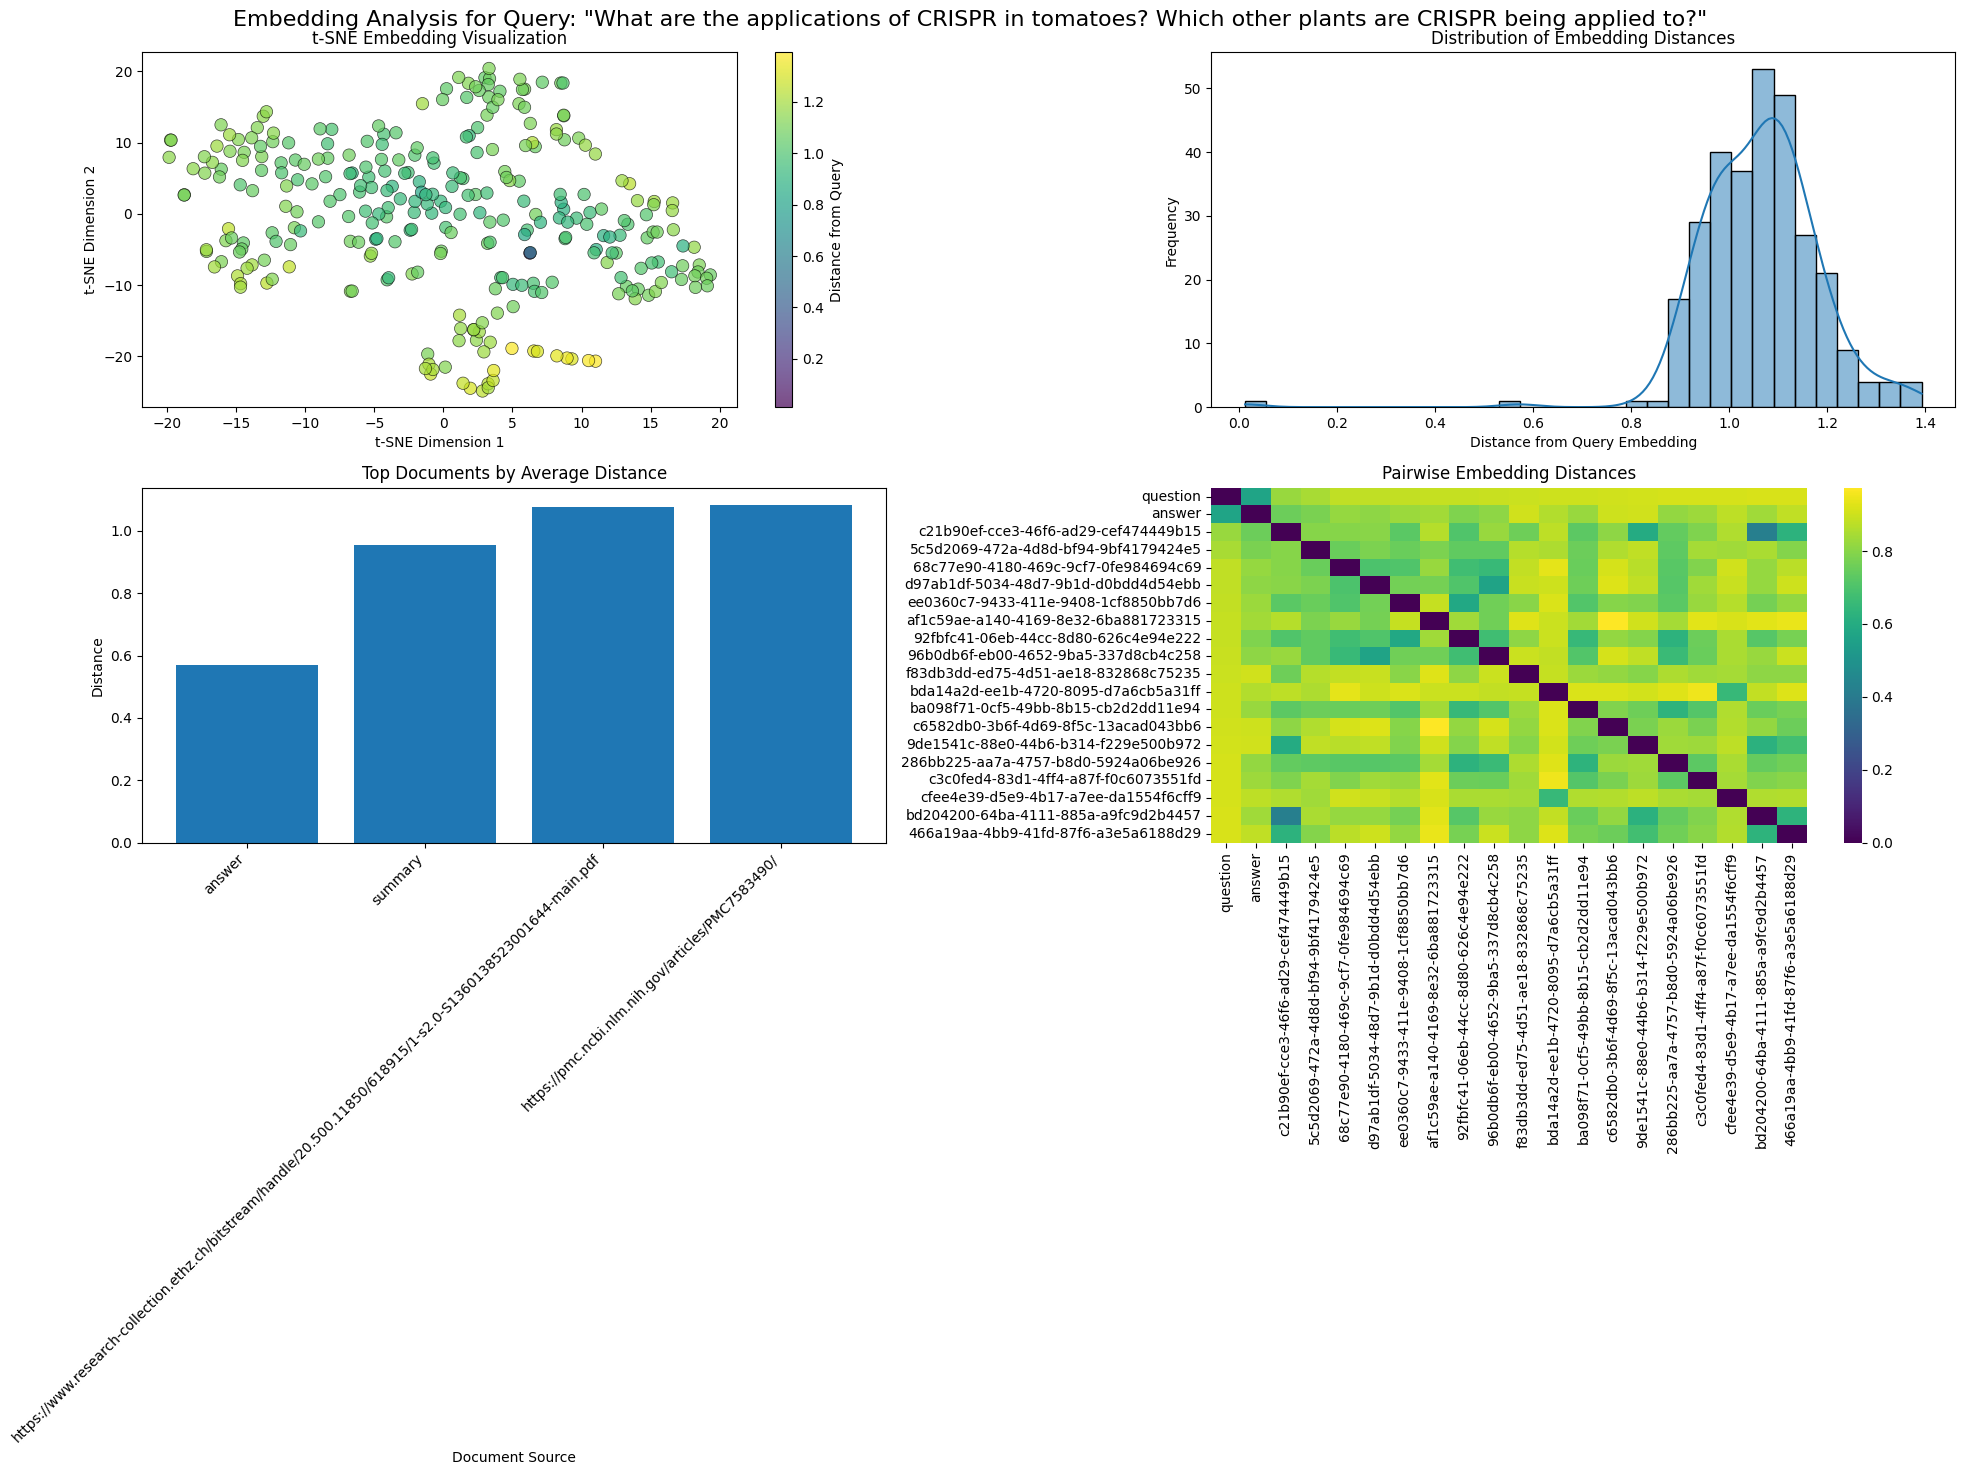

In [22]:
visualize_embeddings(df)

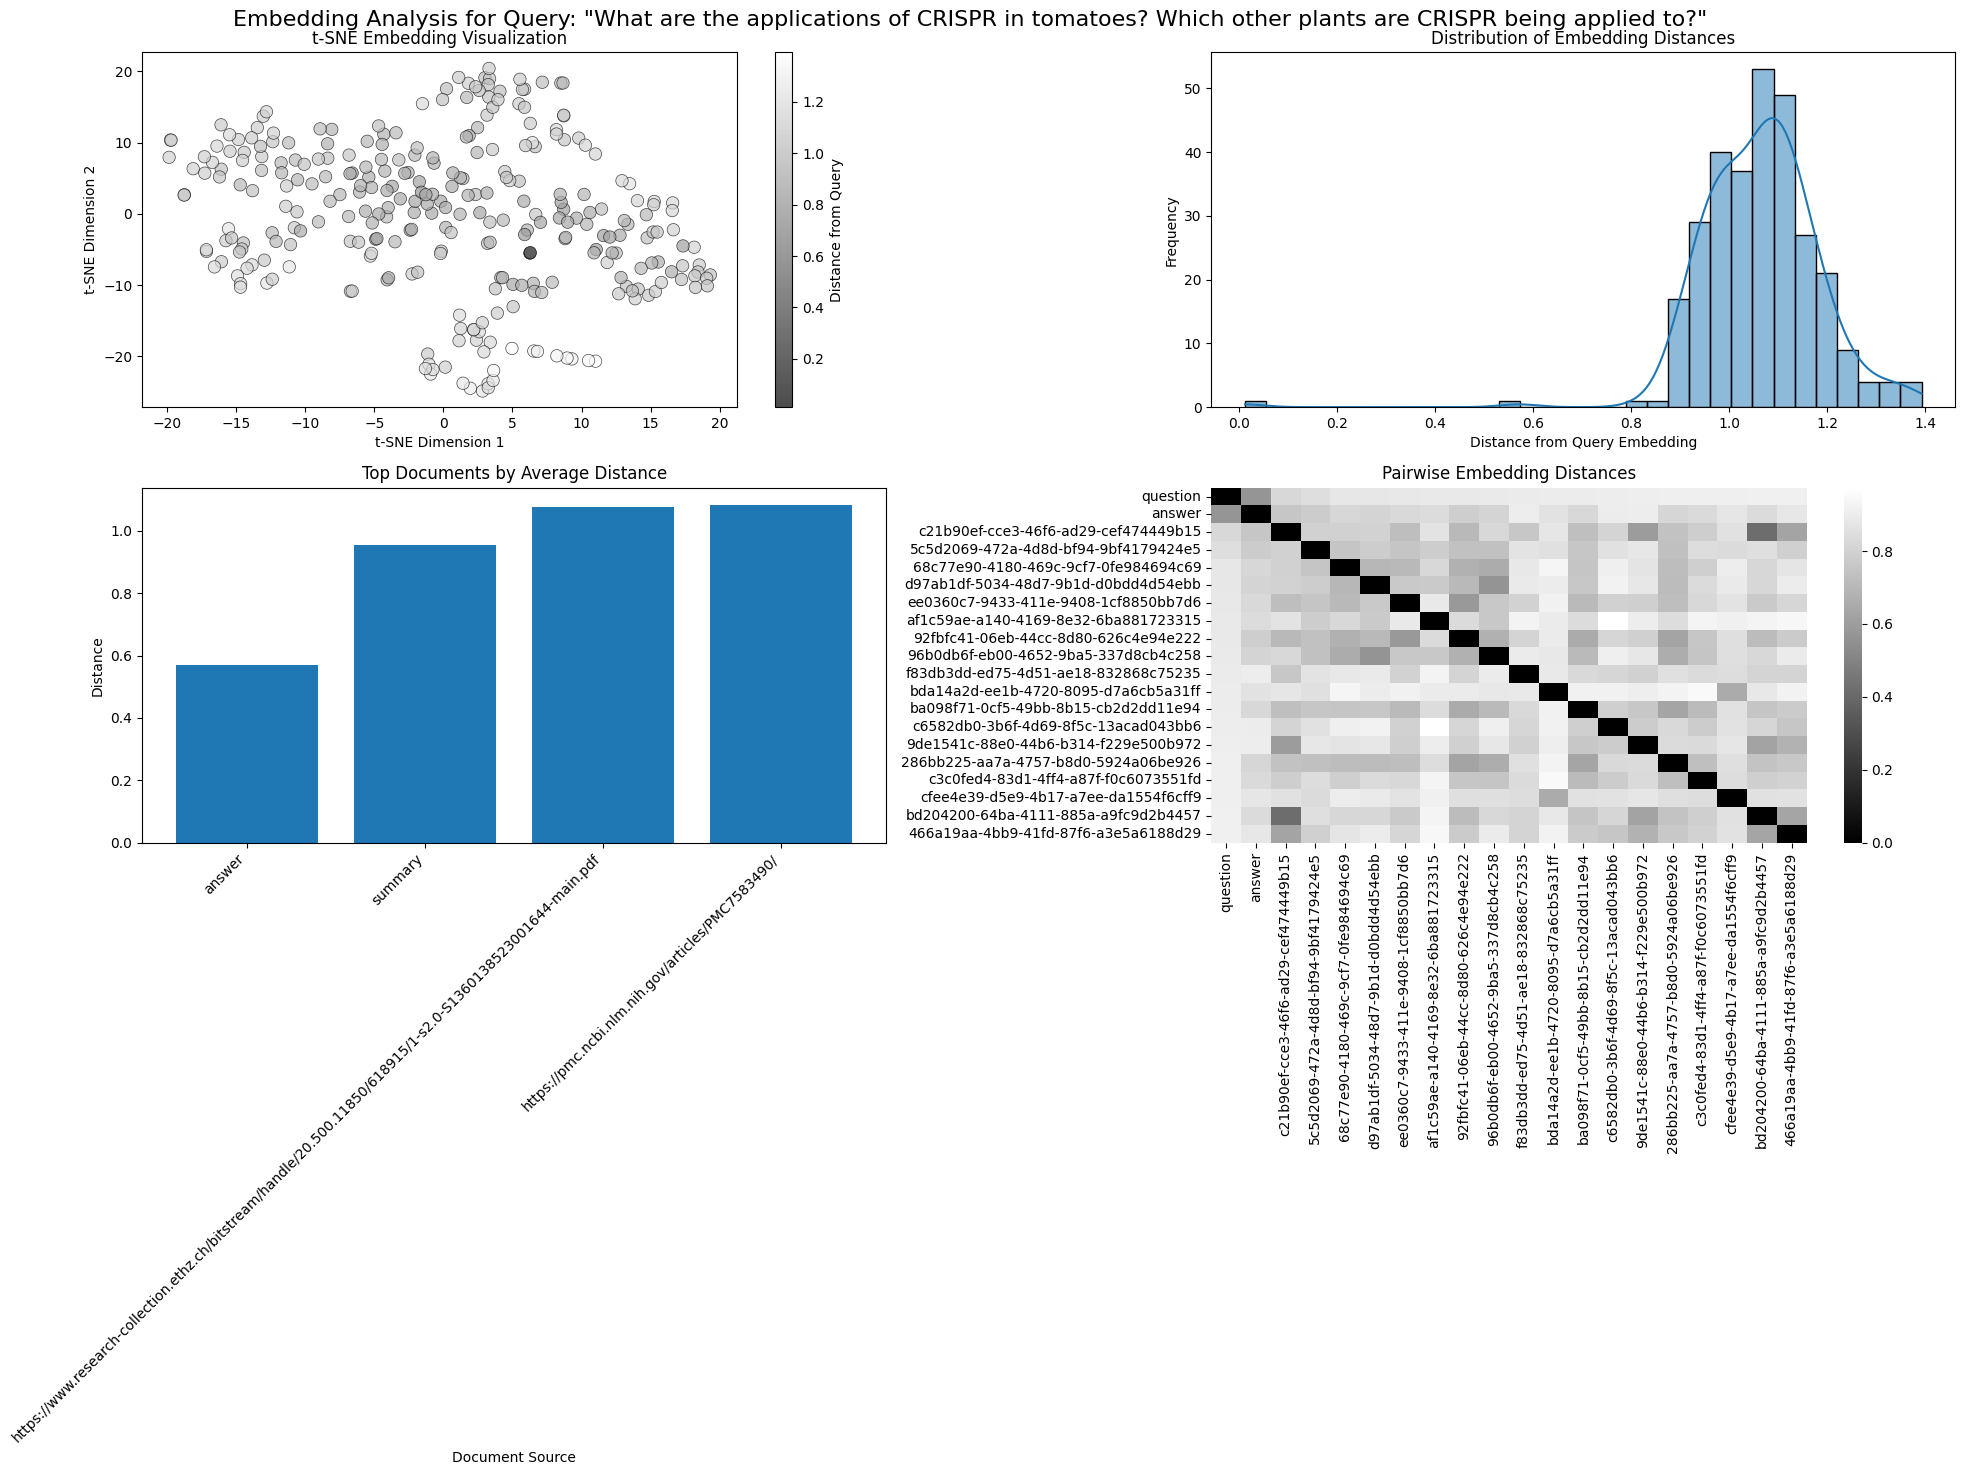

In [23]:
visualize_embeddings(df, mode="bw")

## Advanced Query Techniques

### Query Decomposition

Complex queries can be broken down into simpler sub-questions for better retrieval and answering.
This technique helps handle multi-part questions more effectively.

In [24]:
# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

# Chain
generate_queries_decomposition = (
    prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n"))
)

# Run
question = "Given a specific cancer cell line, what are the key pathways involved in its resistance to both targeted therapy X and immunotherapy Y, and how do these pathways interact at the protein level?"

In [25]:
generate_queries_decomposition.invoke({"question": question})

['1. What are the key signaling pathways associated with resistance to targeted therapy X in the specific cancer cell line? ',
 '',
 '2. How does the specific cancer cell line exhibit resistance to immunotherapy Y, and what pathways are involved in this process?',
 '',
 '3. What are the protein-protein interactions among the key pathways involved in resistance to both targeted therapy X and immunotherapy Y in the specific cancer cell line?']

### Step-Back Prompting

Step-back prompting encourages the model to ask more general questions that might be easier to answer,
leading to better retrieval of relevant background information.

In [26]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples = [
    {
        "input": "What are the key molecular mechanisms involved in the regulation of the circadian rhythm in mammals?",
        "output": "what is the general mechanism of circadian rhythm regulation in living organisms?",
    },
    {
        "input": "How does the microbiome influence the immune system in humans?",
        "output": "what is the role of the microbiome in human health?",
    },
    {
        "input": "What are the primary factors contributing to the development of antibiotic resistance in bacterial populations?",
        "output": "what are the main causes of antibiotic resistance?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge.
            Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer.
            Here are a few examples:""",
        ),
        few_shot_prompt,
        ("user", "{question}"),
    ]
)

In [27]:
generate_queries_step_back = prompt | llm | StrOutputParser()
question = "For a novel drug target Z, what are the potential off-target effects in human cardiomyocytes?"
generate_queries_step_back.invoke({"question": question})

'what are the possible side effects of new drug targets on heart cells?'

## Query Routing

Query routing directs different types of questions to specialized processing chains.
This improves accuracy by using domain-specific knowledge and prompts.

### Structured Output Routing

Using Pydantic models to ensure consistent routing decisions.

In [28]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["chemistry", "drug_discovery", "biology"] = Field(
        ...,
        description="Given a user question, choose which datasource would be most relevant for answering their question",
    )


# LLM with function call
structured_llm = llm.with_structured_output(RouteQuery)

# System prompt
system_prompt = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

# Prompt
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

# Define router
router = prompt | structured_llm

In [29]:
chemistry_question = """What are the thermodynamic properties of the
compound formed when chlorine reacts with benzene under light?
"""

In [30]:
route_result = router.invoke({"question": chemistry_question})
print(f"Question: {chemistry_question}")
print(f"Routed to: {route_result.datasource}")

Question: What are the thermodynamic properties of the
compound formed when chlorine reacts with benzene under light?

Routed to: chemistry


### Route Execution

Based on the routing decision, we can direct queries to specialized processing chains.

In [31]:
from langchain_core.runnables import RunnableLambda


def choose_route(result):
    if "chemistry" in result.datasource.lower():
        return "chemical chain"  # Chemistry-related logic here
    elif "drug_discovery" in result.datasource.lower():
        return "drug_discovery chain"  # Drug discovery-related logic here
    else:
        return "biology chain"  # Logic related to biology here


full_chain = router | RunnableLambda(choose_route)

In [32]:
full_chain.invoke({"question": question})

'drug_discovery chain'

### Semantic Routing

Alternative routing approach using embedding similarity to match queries with appropriate prompts.


In [33]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Three prompts
chemistry_template = """You are a very knowledgeable chemistry professor. \
You excel at answering questions about chemistry in a clear and understandable manner. \
When you don't know the answer to a question, you admit that you don't know.

Here is a question:
{query}"""

drug_discovery_template = """You are an expert in drug discovery. You are adept at answering questions related to drug discovery processes, methodologies, and technologies. \
You break down complex problems into simpler components to provide comprehensive answers.

Here is a question:
{query}"""

biology_template = """You are a very knowledgeable biology professor. \
You are great at answering questions about biology in a concise and easy-to-understand manner. \
When you don't know the answer to a question, you admit that you don't know.

Here is a question:
{query}"""

# Embed prompts
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
prompt_templates = [chemistry_template, drug_discovery_template, biology_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)


# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    if most_similar == chemistry_template:
        print("chemical chain")  # Chemistry-related logic here
    elif most_similar == drug_discovery_template:
        print("drug_discovery chain")  # Drug discovery-related logic here
    else:
        print("biology chain")  # Logic related to biology here
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

In [34]:
chain.invoke(question)

drug_discovery chain


'When identifying potential off-target effects for a novel drug target Z in human cardiomyocytes, it is crucial to consider several factors. \n\nFirstly, it is important to assess the specificity of the drug target Z and any potential structural homologs or closely related proteins that could be mistakenly targeted by the drug. This can be done through computational modeling, screening against large databases of known proteins, and in vitro testing.\n\nSecondly, the expression pattern of the drug target Z in cardiomyocytes should be evaluated. If the target is highly expressed in cardiomyocytes, there is a higher likelihood of on-target effects. Conversely, if the target is minimally expressed in cardiomyocytes but highly expressed in other tissues, the risk of off-target effects in cardiomyocytes may be lower.\n\nAdditionally, the potential downstream signaling pathways and biological processes that may be affected by targeting drug Z should be considered. For example, if drug Z modul

## SQL Agent Integration

Integrating structured database queries with RAG allows for precise factual retrieval
alongside semantic search capabilities.

### Database Setup

Creating a sample biological research database to demonstrate SQL agent capabilities.

In [35]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect("BiologyResearch.db")
cursor = conn.cursor()

# Create a table for biological experiments
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS BiologicalExperiments (
    id INTEGER PRIMARY KEY,
    experiment_title TEXT NOT NULL,
    research_area TEXT NOT NULL,
    organism_studied TEXT NOT NULL,
    treatment TEXT,
    control_group TEXT,
    sample_size INTEGER,
    duration_days INTEGER,
    temperature_celsius REAL,
    ph_level REAL,
    nitrogen_fixation_rate REAL,
    photosynthesis_efficiency REAL,
    growth_rate REAL,
    gene_expression_change TEXT,
    protein_yield_mg REAL,
    compound_produced TEXT,
    success_rate REAL)
"""
)

# Sample data for biological experiments
experiments_data = [
    (
        1,
        "Rhizobium-Legume Symbiosis in Phaseolus vulgaris",
        "Plant-Microbe Interactions",
        "Phaseolus vulgaris",
        "Rhizobium inoculation",
        "No inoculation",
        50,
        45,
        25.5,
        6.8,
        78.3,
        None,
        0.45,
        "Up-regulation of nifH, nodA",
        None,
        None,
        92.5,
    ),
    (
        2,
        "Bradyrhizobium-Soybean Symbiotic Efficiency",
        "Plant-Microbe Interactions",
        "Glycine max",
        "Bradyrhizobium japonicum strain B6",
        "No inoculation",
        40,
        60,
        27.0,
        6.5,
        85.7,
        None,
        0.52,
        "Increased nodA, nodB expression",
        None,
        None,
        88.0,
    ),
    (
        3,
        "AM Fungi Effects on Tomato Growth",
        "Mycorrhizal Associations",
        "Solanum lycopersicum",
        "Glomus intraradices",
        "Non-mycorrhizal control",
        30,
        75,
        24.0,
        6.2,
        None,
        0.67,
        0.38,
        "None",
        None,
        None,
        76.0,
    ),
    (
        4,
        "CRISPR-Cas9 Modification of Rice for Drought Resistance",
        "Gene Editing",
        "Oryza sativa",
        "DREB1A gene insertion",
        "Wild type",
        60,
        90,
        28.5,
        5.9,
        None,
        0.72,
        0.29,
        "DREB1A overexpression",
        None,
        None,
        81.5,
    ),
    (
        5,
        "Medicago-Sinorhizobium Symbiosis Enhancement",
        "Plant-Microbe Interactions",
        "Medicago truncatula",
        "Sinorhizobium meliloti + phosphate",
        "S. meliloti only",
        45,
        50,
        26.0,
        7.0,
        92.1,
        None,
        0.58,
        "Enhanced nifH, exoY expression",
        None,
        None,
        93.8,
    ),
    (
        6,
        "Azospirillum-Wheat Growth Promotion",
        "Plant-Microbe Interactions",
        "Triticum aestivum",
        "Azospirillum brasilense Az39",
        "Uninoculated control",
        55,
        65,
        23.5,
        6.7,
        45.2,
        0.61,
        0.47,
        "IAA pathway genes upregulation",
        None,
        None,
        79.0,
    ),
    (
        7,
        "Protein Engineering for Improved Rubisco Efficiency",
        "Synthetic Biology",
        "Nicotiana tabacum",
        "Engineered rbcL gene",
        "Native rbcL",
        35,
        70,
        26.5,
        6.0,
        None,
        0.88,
        0.41,
        "rbcL variant expression",
        125.3,
        None,
        68.5,
    ),
    (
        8,
        "Microalgal Biomass Production Optimization",
        "Biofuel Research",
        "Chlorella vulgaris",
        "High CO2 + LED lighting",
        "Ambient CO2, natural light",
        40,
        30,
        30.0,
        7.2,
        None,
        0.93,
        0.76,
        "None",
        None,
        "Triacylglycerol",
        87.2,
    ),
    (
        9,
        "Azorhizobium-Sesbania Nodulation Efficiency",
        "Plant-Microbe Interactions",
        "Sesbania rostrata",
        "Azorhizobium caulinodans ORS571",
        "No inoculation",
        50,
        55,
        29.0,
        6.8,
        88.9,
        None,
        0.49,
        "nodD, nifA upregulation",
        None,
        None,
        91.0,
    ),
    (
        10,
        "Bacillus Endophyte Growth Promotion in Corn",
        "Plant-Microbe Interactions",
        "Zea mays",
        "Bacillus amyloliquefaciens FZB42",
        "No endophyte",
        60,
        85,
        25.0,
        6.5,
        32.1,
        0.58,
        0.62,
        "Defense-related genes induction",
        None,
        None,
        74.5,
    ),
    (
        11,
        "Methanotroph-Based Bioremediation",
        "Environmental Microbiology",
        "Methylosinus trichosporium",
        "Copper-enhanced medium",
        "Standard medium",
        30,
        25,
        22.0,
        6.3,
        None,
        None,
        0.38,
        "pmoA gene induction",
        None,
        "Methanol",
        69.8,
    ),
    (
        12,
        "Clostridium Biofuel Production",
        "Industrial Microbiology",
        "Clostridium acetobutylicum",
        "Modified fermentation process",
        "Standard process",
        45,
        15,
        32.5,
        5.5,
        None,
        None,
        0.29,
        "None",
        None,
        "Butanol",
        77.3,
    ),
    (
        13,
        "Root Nodule Development in Alfalfa",
        "Plant-Microbe Interactions",
        "Medicago sativa",
        "Sinorhizobium meliloti + molybdenum",
        "S. meliloti only",
        55,
        60,
        24.5,
        7.1,
        95.3,
        None,
        0.51,
        "Enhanced nodulation gene expression",
        None,
        None,
        94.6,
    ),
    (
        14,
        "Frankia-Actinorhizal Plant Symbiosis",
        "Plant-Microbe Interactions",
        "Alnus glutinosa",
        "Frankia alni strain ACN14a",
        "No inoculation",
        40,
        90,
        23.0,
        6.6,
        76.8,
        None,
        0.44,
        "Nitrogen fixation genes upregulation",
        None,
        None,
        85.9,
    ),
    (
        15,
        "CAM Photosynthesis Engineering in Rice",
        "Metabolic Engineering",
        "Oryza sativa",
        "PEPC gene from Agave",
        "Wild type",
        50,
        120,
        28.0,
        6.0,
        None,
        0.75,
        0.33,
        "PEPC, PPDK expression",
        None,
        None,
        62.4,
    ),
    (
        16,
        "Mesorhizobium-Lotus Symbiosis",
        "Plant-Microbe Interactions",
        "Lotus japonicus",
        "Mesorhizobium loti MAFF303099",
        "No inoculation",
        45,
        65,
        26.0,
        6.9,
        82.6,
        None,
        0.47,
        "nodA, nifH expression",
        None,
        None,
        89.2,
    ),
    (
        17,
        "Synthetic Microbial Consortia for Bioremediation",
        "Synthetic Biology",
        "Mixed consortium",
        "Engineered synergistic consortium",
        "Individual strains",
        35,
        40,
        24.0,
        7.3,
        None,
        None,
        0.53,
        "Cross-species signaling genes",
        None,
        "Multiple metabolites",
        73.8,
    ),
    (
        18,
        "Rhizobial Enhancement of Pea Nodulation",
        "Plant-Microbe Interactions",
        "Pisum sativum",
        "Rhizobium leguminosarum + flavonoids",
        "R. leguminosarum only",
        60,
        55,
        22.5,
        6.7,
        79.4,
        None,
        0.56,
        "Increased nod gene expression",
        None,
        None,
        87.5,
    ),
    (
        19,
        "Metagenomic Analysis of Soil Microbiome",
        "Microbial Ecology",
        "Soil community",
        "Fertilizer treatment",
        "Unfertilized soil",
        40,
        180,
        20.0,
        6.4,
        None,
        None,
        None,
        "Diversity shifts in N-cycling genes",
        None,
        "Various metabolites",
        82.0,
    ),
    (
        20,
        "Bradyrhizobium-Cowpea Nitrogen Fixation",
        "Plant-Microbe Interactions",
        "Vigna unguiculata",
        "Bradyrhizobium sp. strain CB756",
        "No inoculation",
        50,
        70,
        27.5,
        6.8,
        84.2,
        None,
        0.50,
        "nifH, fixA, nodD upregulation",
        None,
        None,
        90.1,
    ),
]

# Insert data into the table
cursor.executemany(
    """
INSERT OR REPLACE INTO BiologicalExperiments (
    id, experiment_title, research_area, organism_studied, treatment, control_group,
    sample_size, duration_days, temperature_celsius, ph_level, nitrogen_fixation_rate,
    photosynthesis_efficiency, growth_rate, gene_expression_change, protein_yield_mg,
    compound_produced, success_rate
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""",
    experiments_data,
)

In [36]:
cursor.execute("SELECT * from BiologicalExperiments limit 10")
column_names = [desc[0] for desc in cursor.description]
data = cursor.fetchall()

conn.commit()
conn.close()

Now we'll create a SQL agent that can interact with our database using natural language queries.


In [37]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain.prompts import PromptTemplate

# Initialize the SQL database connection
db = SQLDatabase.from_uri("sqlite:///BiologyResearch.db")

# Define a prompt template that includes the agent_scratchpad variable
prompt_template = """
You are an agent designed to interact with a SQL database.

User question: {input}

{agent_scratchpad}
"""

prompt = PromptTemplate.from_template(prompt_template)

# Create the SQL agent
agent = create_sql_agent(
    llm=llm,
    db=db,
    prompt=prompt,
    agent_type="openai-tools",
    verbose=True,
)

In [38]:
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,Rhizobium-Legume Symbiosis in Phaseolus vulgaris,Plant-Microbe Interactions,Phaseolus vulgaris,Rhizobium inoculation,No inoculation,50,45,25.5,6.8,78.3,NaN,0.45,"Up-regulation of nifH, nodA",NaN,None,92.5
1,2,Bradyrhizobium-Soybean Symbiotic Efficiency,Plant-Microbe Interactions,Glycine max,Bradyrhizobium japonicum strain B6,No inoculation,40,60,27.0,6.5,85.7,NaN,0.52,"Increased nodA, nodB expression",NaN,None,88.0
2,3,AM Fungi Effects on Tomato Growth,Mycorrhizal Associations,Solanum lycopersicum,Glomus intraradices,Non-mycorrhizal control,30,75,24.0,6.2,NaN,0.67,0.38,None,NaN,None,76.0
3,4,CRISPR-Cas9 Modification of Rice for Drought R...,Gene Editing,Oryza sativa,DREB1A gene insertion,Wild type,60,90,28.5,5.9,NaN,0.72,0.29,DREB1A overexpression,NaN,None,81.5
4,5,Medicago-Sinorhizobium Symbiosis Enhancement,Plant-Microbe Interactions,Medicago truncatula,Sinorhizobium meliloti + phosphate,S. meliloti only,45,50,26.0,7.0,92.1,NaN,0.58,"Enhanced nifH, exoY expression",NaN,None,93.8
5,6,Azospirillum-Wheat Growth Promotion,Plant-Microbe Interactions,Triticum aestivum,Azospirillum brasilense Az39,Uninoculated control,55,65,23.5,6.7,45.2,0.61,0.47,IAA pathway genes upregulation,NaN,None,79.0
6,7,Protein Engineering for Improved Rubisco Effic...,Synthetic Biology,Nicotiana tabacum,Engineered rbcL gene,Native rbcL,35,70,26.5,6.0,NaN,0.88,0.41,rbcL variant expression,125.3,None,68.5
7,8,Microalgal Biomass Production Optimization,Biofuel Research,Chlorella vulgaris,High CO2 + LED lighting,"Ambient CO2, natural light",40,30,30.0,7.2,NaN,0.93,0.76,None,NaN,Triacylglycerol,87.2
8,9,Azorhizobium-Sesbania Nodulation Efficiency,Plant-Microbe Interactions,Sesbania rostrata,Azorhizobium caulinodans ORS571,No inoculation,50,55,29.0,6.8,88.9,NaN,0.49,"nodD, nifA upregulation",NaN,None,91.0
9,10,Bacillus Endophyte Growth Promotion in Corn,Plant-Microbe Interactions,Zea mays,Bacillus amyloliquefaciens FZB42,No endophyte,60,85,25.0,6.5,32.1,0.58,0.62,Defense-related genes induction,NaN,None,74.5


In [39]:
agent.invoke(
    {
        "input": "How many plant-microbe interaction experiments have resulted in increased nitrogen fixation in legumes?"
    }
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


BiologicalExperiments
Invoking: `sql_db_schema` with `{'table_names': 'BiologicalExperiments'}`



CREATE TABLE "BiologicalExperiments" (
	id INTEGER, 
	experiment_title TEXT NOT NULL, 
	research_area TEXT NOT NULL, 
	organism_studied TEXT NOT NULL, 
	treatment TEXT, 
	control_group TEXT, 
	sample_size INTEGER, 
	duration_days INTEGER, 
	temperature_celsius REAL, 
	ph_level REAL, 
	nitrogen_fixation_rate REAL, 
	photosynthesis_efficiency REAL, 
	growth_rate REAL, 
	gene_expression_change TEXT, 
	protein_yield_mg REAL, 
	compound_produced TEXT, 
	success_rate REAL, 
	PRIMARY KEY (id)
)

/*
3 rows from BiologicalExperiments table:
id	experiment_title	research_area	organism_studied	treatment	control_group	sample_size	duration_days	temperature_celsius	ph_level	nitrogen_fixation_rate	photosynthesis_efficiency	growth_rate	gene_expression_change	protein_yield_mg	compound_produced	success_rate
1	Rhizobium-

{'input': 'How many plant-microbe interaction experiments have resulted in increased nitrogen fixation in legumes?',
 'output': 'There have been 11 plant-microbe interaction experiments that resulted in increased nitrogen fixation in legumes.'}

We'll implement a structured query constructor for more complex document retrieval operations.


In [40]:
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt,
)
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage

# Define document context and metadata information
document_content_description = "Scientific articles"
metadata_field_info = [
    {
        "name": "publication_type",
        "type": "string",
        "description": "Type of publication",
    },
    {"name": "year", "type": "integer", "description": "Year of publication"},
    {
        "name": "return",
        "type": "integer",
        "description": "Number of publications to return",
    },
]

# Create prompt and output parser
prompt = get_query_constructor_prompt(document_content_description, metadata_field_info)
output_parser = StructuredQueryOutputParser.from_components()

# Create query constructor chain
query_constructor = prompt | llm | output_parser

# Example query
query = "10 recent articles after 2020 on CRISPR gene editing in plant biology focusing on increasing crop yield"

In [41]:
query_constructor.invoke({"query": query})

StructuredQuery(query='CRISPR gene editing plant biology increasing crop yield', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.GT: 'gt'>, attribute='year', value=2020), Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='return', value=10)]), limit=None)

## Evaluation
This section creates a comprehensive evaluation dataset for testing our RAG system.

In [42]:
EVAL_MODE = (
    True  # this will activate eval part, but it'll take time to run it end-to-end
)

### Creating evaluation dataset

In [43]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [44]:
if EVAL_MODE:
    pdf_links = [
        "https://www.nobelprize.org/uploads/2022/10/advanced-chemistryprize2022.pdf",
        "https://www.nobelprize.org/uploads/2023/10/advanced-chemistryprize2023.pdf",
        "https://www.nobelprize.org/uploads/2024/10/advanced-chemistryprize2024.pdf",
    ]

    pdf_doc = flatten(
        [pdf_loader.load() for pdf_loader in [PyPDFLoader(link) for link in pdf_links]]
    )

In [45]:
from langchain_anthropic import ChatAnthropic

llm_eval = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)

In [46]:
if EVAL_MODE:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in pdf_doc:
        docs_processed += text_splitter.split_documents([doc])

In [47]:
from tqdm import tqdm
import json

np.random.seed(0)
if EVAL_MODE:
    QA_generation_prompt_template = """
  Your task is to write a factoid question and an answer given a context.
  Your factoid question should be answerable with a specific, concise piece of factual information from the context.
  Your factoid question should be formulated in the same style as questions users could ask in a search engine.
  This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

  Provide your answer as follows:

  Output:
  Factoid question: (your factoid question)
  Answer: (your answer to the factoid question)

  Now here is the context.

  Context: {context}\n
  Output:
  """

    prompt = PromptTemplate.from_template(QA_generation_prompt_template)
    llm_eval_chain = prompt | llm_eval | StrOutputParser()
    # Generating only 10 QA couples here for cost and time considerations
    N_GENERATIONS = 10

    print(f"Generating {N_GENERATIONS} QA couples...")

    outputs = []
    for sampled_context in tqdm(np.random.choice(docs_processed, N_GENERATIONS)):
        output_QA_couple = llm_eval_chain.invoke(
            {"context": sampled_context.page_content}
        )
        try:
            question = output_QA_couple.split("Factoid question: ")[-1].split(
                "Answer: "
            )[0]
            answer = output_QA_couple.split("Answer: ")[-1]
            assert len(answer) < 300, "Answer is too long"
            outputs.append(
                {
                    "context": sampled_context.page_content,
                    "question": question,
                    "answer": answer,
                    "source_doc": sampled_context.metadata["source"],
                }
            )
        except Exception as e:
            print(f"Exception: {e}")
            continue

Generating 10 QA couples...


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


In [48]:
if EVAL_MODE:
    with open("eval_dataset.json", "w") as fp:
        json.dump(outputs, fp)

In [49]:
with open("eval_dataset.json", "r") as fp:
    outputs = json.load(fp)

In [50]:
pd.DataFrame(outputs)

,context,question,answer,source_doc
0,"16 (18) \n \n(28) Rodriguez, E. C.; Marcaurel...",Who discovered the Staudinger reaction?\n\n,Hermann Staudinger and Jacob Meyer discovered ...,https://www.nobelprize.org/uploads/2022/10/adv...
1,Nobel Prize ® and the Nobel Prize ® medal desi...,When will the Nobel Prize in Chemistry be awar...,9 October 2024,https://www.nobelprize.org/uploads/2024/10/adv...
2,glass.26 It was also understood that the glass...,When did Aleksey Yekimov start working on dope...,In 1979.,https://www.nobelprize.org/uploads/2023/10/adv...
3,"Electrolyte. At&T Tech J 1955, 34 (1), 129-176...",Who discovered the electrochemical photolysis ...,Fujishima and Honda discovered the electrochem...,https://www.nobelprize.org/uploads/2023/10/adv...
4,• They should be stereospecific (but not neces...,What is the minimum thermodynamic driving forc...,The minimum recommended thermodynamic driving ...,https://www.nobelprize.org/uploads/2022/10/adv...
5,8 (18) \n \nexperiments are performed at close...,What type of reaction experienced a dramatic u...,The copper-catalyzed azide-alkyne cycloadditio...,https://www.nobelprize.org/uploads/2022/10/adv...
6,"its discovery.\n59 Thus, tumours could be targ...",What type of reaction was used to target tumor...,The IEDDA (inverse electron-demand Diels-Alder...,https://www.nobelprize.org/uploads/2022/10/adv...
7,10 (17) \nCd\nSe/ZnS core-shell quantum dots h...,What was the luminescence quantum yield of CdS...,The luminescence quantum yield of CdSe/ZnS cor...,https://www.nobelprize.org/uploads/2023/10/adv...
8,average radius 𝒂𝒂� of CuCl nanocrystals i n g ...,How does the energy of the absorption line cha...,The energy of the absorption line increases pr...,https://www.nobelprize.org/uploads/2023/10/adv...
9,"group bonded to Zn on the quantum dot, displac...",What advantage do functionalized quantum dots ...,Functionalized quantum dots offer better stabi...,https://www.nobelprize.org/uploads/2023/10/adv...


We'll evaluate the generated questions on three criteria: groundedness, relevance, and standalone quality.


In [51]:
question_groundedness_critique_prompt_template = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer: """

question_relevance_critique_prompt_template = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question is regarding Chemistry Nobel Prize winners history.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer: """

question_standalone_critique_prompt_template = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical and chemical nouns or acronyms and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "When should the Nobel Prize ceremony take place?" should receive a 1, since the question is not independent from the context.

Provide your answer as follows:

Answer:
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer: """

In [52]:
if EVAL_MODE:
    question_groundedness_critique_prompt = PromptTemplate.from_template(
        question_groundedness_critique_prompt_template
    )
    question_relevance_critique_prompt = PromptTemplate.from_template(
        question_relevance_critique_prompt_template
    )
    question_standalone_critique_prompt = PromptTemplate.from_template(
        question_standalone_critique_prompt_template
    )
    llm_groundedness_chain = (
        question_groundedness_critique_prompt | llm_eval | StrOutputParser()
    )
    llm_relevance_chain = (
        question_relevance_critique_prompt | llm_eval | StrOutputParser()
    )
    llm_standalone_chain = (
        question_standalone_critique_prompt | llm_eval | StrOutputParser()
    )

    print("Generating critique for each QA couple...")
    for output in tqdm(outputs):

        evaluations = {
            "groundedness": llm_groundedness_chain.invoke(
                {"context": output["context"], "question": output["question"]}
            ),
            "relevance": llm_relevance_chain.invoke({"question": output["question"]}),
            "standalone": llm_standalone_chain.invoke({"question": output["question"]}),
        }
        try:
            for criterion, evaluation in evaluations.items():
                score, eval = (
                    int(evaluation.split("Total rating: ")[-1].strip()),
                    evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
                )
                output.update(
                    {
                        f"{criterion}_score": score,
                        f"{criterion}_eval": eval,
                    }
                )
        except Exception as e:
            continue

    generated_questions = pd.DataFrame.from_dict(outputs)

Generating critique for each QA couple...


100%|██████████| 10/10 [01:38<00:00,  9.88s/it]


Evaluation process

In [53]:
if EVAL_MODE:
    generated_questions_filtered = generated_questions.loc[
        (generated_questions["groundedness_score"] >= 3)
        & (generated_questions["relevance_score"] >= 3)
        & (generated_questions["standalone_score"] >= 3)
    ]
    print("============================================")
    print("Final evaluation dataset:")
    print(
        generated_questions_filtered[
            [
                "question",
                "answer",
                "groundedness_score",
                "relevance_score",
                "standalone_score",
            ]
        ]
    )

Final evaluation dataset:
                                            question  \
0        Who discovered the Staudinger reaction?\n\n   
3  Who discovered the electrochemical photolysis ...   
9  What advantage do functionalized quantum dots ...   

                                              answer  groundedness_score  \
0  Hermann Staudinger and Jacob Meyer discovered ...                   5   
3  Fujishima and Honda discovered the electrochem...                   4   
9  Functionalized quantum dots offer better stabi...                   5   

   relevance_score  standalone_score  
0                5                 5  
3                4                 5  
9                4                 5  


## RAG System Testing
This section implements a comprehensive testing framework for different RAG configurations.


In [54]:
from typing import List, Dict, Any, Callable, Tuple
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""


def iterate_chunk_embedding_combinations(
    pdf_links: List[str],
    text_splitters: List[Tuple[str, RecursiveCharacterTextSplitter]],
    embedding_models: List[Tuple[str, Any]],
    llm_models: List[Tuple[str, Any]],
    prompt_templates: List[Tuple[str, Any]],
    extract_text_before_references: Callable = None,
    retriever_types: List[str] = ["mmr", "similarity"],
    k_values: List[int] = [3, 5],
) -> Dict[str, Any]:
    """
    Generic function to iterate through all possible chunk and embedding combinations.

    Args:
        pdf_links: List of PDF links to load documents from
        text_splitters: List of tuples (name, splitter) of text splitters
        embedding_models: List of tuples (name, model) of embedding models
        llm_models: List of tuples (name, model) of LLM models
        prompt_templates: List of tuples (name, template) of prompt templates
        extract_text_before_references: Optional function to extract text before references
        retriever_types: List of retriever types to use
        k_values: List of k values for retriever

    Returns:
        Dictionary with results of all combinations
    """
    results = {}

    # Store all chunks for each splitter
    chunks_by_splitter = {}

    # Step 1: Process all documents with each text splitter
    print("Step 1: Processing documents with text splitters...")
    for splitter_name, text_splitter in text_splitters:
        print(f"  Processing with {splitter_name}...")

        chunks_with_ref = []
        chunks_no_ref = []

        for link in pdf_links:
            pdf_loader = PyPDFLoader(link)
            doc = pdf_loader.load()

            # Split documents
            chunks = text_splitter.split_documents(doc)
            chunks_with_ref.extend(chunks)

            # Extract text before references if function provided
            if extract_text_before_references:
                filtered_chunks = extract_text_before_references(chunks)
                chunks_no_ref.extend(filtered_chunks)
            else:
                chunks_no_ref.extend(chunks)

        # Store chunks for future use
        if extract_text_before_references:
            chunks_by_splitter[f"{splitter_name}_with_ref"] = chunks_with_ref
            chunks_by_splitter[f"{splitter_name}_no_ref"] = chunks_no_ref
        else:
            chunks_by_splitter[splitter_name] = chunks_no_ref

    # Step 2: Create vectorstores for each chunk set and embedding model
    print("Step 2: Creating vectorstores for each combination...")
    vectorstores = {}
    for chunk_key, chunks in chunks_by_splitter.items():
        for emb_name, embedding_model in embedding_models:
            store_key = f"{chunk_key}_{emb_name}"
            print(f"  Creating vectorstore: {store_key}")
            vectorstores[store_key] = FAISS.from_documents(
                documents=chunks, embedding=embedding_model
            )

    # Step 3: Create retrievers for each vectorstore and retriever type
    print("Step 3: Creating retrievers...")
    retrievers = {}
    for store_key, vectorstore in vectorstores.items():
        for retriever_type in retriever_types:
            for k in k_values:
                retriever_key = f"{store_key}_{retriever_type}_k{k}"
                print(f"  Creating retriever: {retriever_key}")
                retrievers[retriever_key] = vectorstore.as_retriever(
                    search_type=retriever_type, search_kwargs={"k": k}
                )

    # Step 4: Create retrieval chains for each combination
    print("Step 4: Creating retrieval chains...")
    chains = {}
    for prompt_name, prompt_template in prompt_templates:
        for llm_name, llm in llm_models:
            # Create stuff documents chain
            combine_docs_chain = create_stuff_documents_chain(llm, prompt_template)

            for retriever_key, retriever in retrievers.items():
                chain_key = f"{retriever_key}_{llm_name}_{prompt_name}"
                print(f"  Creating chain: {chain_key}")
                chains[chain_key] = create_retrieval_chain(
                    retriever, combine_docs_chain
                )

    # Return all created objects for further use or evaluation
    return {
        "chunks_by_splitter": chunks_by_splitter,
        "vectorstores": vectorstores,
        "retrievers": retrievers,
        "chains": chains,
    }


if EVAL_MODE:

    # Define text splitters
    text_splitters = [
        (
            "splitter_400_50",
            RecursiveCharacterTextSplitter(
                chunk_size=400,
                chunk_overlap=50,
                separators=["\n"],
                keep_separator=False,
            ),
        ),
        (
            "splitter_300_100",
            RecursiveCharacterTextSplitter(
                chunk_size=300,
                chunk_overlap=100,
                separators=["\n"],
                keep_separator=False,
            ),
        ),
    ]

    # Define embedding models
    embedding_models = [
        ("openai", OpenAIEmbeddings(model="text-embedding-3-large")),
        (
            "mpnet",
            HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"),
        ),
    ]

    # Define LLM models
    llm_models = [
        ("gpt-4o-mini", ChatOpenAI(temperature=0, model="gpt-4o-mini")),
        ("gpt-3.5-turbo", ChatOpenAI(temperature=0, model="gpt-3.5-turbo")),
    ]

    # Define prompt templates
    prompt_templates = [
        # ("hub_prompt", None),  # You would pull this from hub in actual code
        (
            "custom_prompt",
            ChatPromptTemplate.from_messages(
                [
                    (
                        "system",
                        "Answer any user questions based solely on the context below:\n<context>\n{context}\n</context>",
                    ),
                    ("placeholder", "{chat_history}"),
                    ("human", "{input}"),
                ]
            ),
        )
    ]

    # Run the function
    combinations = iterate_chunk_embedding_combinations(
        pdf_links=pdf_links,
        text_splitters=text_splitters,
        embedding_models=embedding_models,
        llm_models=llm_models,
        prompt_templates=prompt_templates,
        extract_text_before_references=extract_text_before_references,
        retriever_types=["mmr", "similarity"],
        k_values=[3, 5],
    )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Step 1: Processing documents with text splitters...
  Processing with splitter_400_50...
  Processing with splitter_300_100...
Step 2: Creating vectorstores for each combination...
  Creating vectorstore: splitter_400_50_with_ref_openai
  Creating vectorstore: splitter_400_50_with_ref_mpnet
  Creating vectorstore: splitter_400_50_no_ref_openai
  Creating vectorstore: splitter_400_50_no_ref_mpnet
  Creating vectorstore: splitter_300_100_with_ref_openai
  Creating vectorstore: splitter_300_100_with_ref_mpnet
  Creating vectorstore: splitter_300_100_no_ref_openai
  Creating vectorstore: splitter_300_100_no_ref_mpnet
Step 3: Creating retrievers...
  Creating retriever: splitter_400_50_with_ref_openai_mmr_k3
  Creating retriever: splitter_400_50_with_ref_openai_mmr_k5
  Creating retriever: splitter_400_50_with_ref_openai_similarity_k3
  Creating retriever: splitter_400_50_with_ref_openai_similarity_k5
  Creating retriever: splitter_400_50_with_ref_mpnet_mmr_k3
  Creating retriever: splitter

## Evaluation and Results Analysis

In [55]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

# Create evaluation prompt
evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [56]:
from langchain_core.language_models import BaseChatModel
import plotly.express as px


def run_rag_tests(
    eval_dataset,
    chain,
    chain_key,
    verbose: bool = False,
) -> None:
    """
    Run RAG tests on the given dataset and save results.

    Args:
        eval_dataset: The dataset to evaluate on
        chain: The RAG chain to use
        verbose: Whether to print verbose output
    """
    results = []
    for example in tqdm(eval_dataset):
        if "answer" in example:
            question = example["question"]

            # Get answer using the chain
            result = chain.invoke({"input": question})
            answer = result["answer"]
            relevant_docs = result.get("context", [])

            if verbose:
                print("=" * 50)
                print(f"Question: {question}")
                print(f"Answer: {answer}")
                print(f"True answer: {example['answer']}")

            # Save the result
            result = {
                "experiment": chain_key,
                "question": question,
                "true_answer": example["answer"],
                "generated_answer": answer,
                "retrieved_docs": (
                    [doc.page_content for doc in relevant_docs]
                    if hasattr(relevant_docs, "__iter__")
                    else []
                ),
            }

            results.append(result)

    return results


def evaluate_answers(
    results,
    eval_chat_model,
) -> None:
    """
    Evaluate generated answers using an LLM.

    Args:
        answer_path: Path to the file with answers
        eval_chat_model: The LLM to use for evaluation
        evaluator_name: Name of the evaluator
    """
    # Evaluate each answer
    for idx, experiment in tqdm(enumerate(results)):
        eval_prompt = evaluation_prompt_template.format_messages(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )

        eval_result = eval_chat_model.invoke(eval_prompt)
        feedback, score = [
            item.strip() for item in eval_result.content.split("[RESULT]")
        ]

        results[idx][f"eval_score"] = score
        results[idx][f"eval_feedback"] = feedback

    return results

In [57]:
# Evaluate each chain
all_results = []

if EVAL_MODE:
    for chain_key, chain in combinations["chains"].items():
        print(f"Evaluating chain: {chain_key}")

        responses = run_rag_tests(
            eval_dataset=outputs,
            chain=chain,
            chain_key=chain_key,
            verbose=True,
        )

        # Evaluate answers
        result = evaluate_answers(
            responses,
            eval_chat_model=llm_eval,
        )
        all_results.append(result)

Evaluating chain: splitter_400_50_with_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:11,  1.26s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:11,  1.38s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:11,  1.64s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:08,  1.39s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as reported in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:08<00:09,  1.94s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions, such as modularity, high yields, and reaction conditions. For specific thermodynamic details, additional sources or literature would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:12<00:09,  2.45s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:13<00:06,  2.05s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:14<00:03,  1.74s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:16<00:01,  1.96s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass, as indicated by the relationship \( E \propto \frac{1}{a^2} \).
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells. Additionally, they can be modified to enhance their water solubility and allow for covalent coupling to various functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.65s/it]


Evaluating chain: splitter_400_50_with_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.24it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.13it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.15s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.18s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.39s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions and mentions specific reactions like the thermally induced 1,3-dipolar cycloaddition and the inverse-electron-demand Diels-Alder reaction. For detailed information on thermodynamic driving forces, additional sources or literature on click chemistry would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:06,  1.52s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The 1,3-dipolar cycloaddition reaction, particularly the reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines. This reaction became almost synonymous with the concept of click chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.31s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:02,  1.36s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells. Additionally, they can be made water soluble and allow for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  2.93s/it]


Evaluating chain: splitter_400_50_with_ref_openai_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.24s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the awarding of the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.14s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:09,  1.53s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions, such as modularity, high yields, and reaction conditions. For specific thermodynamic details, additional sources or literature would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:06,  1.57s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:10<00:04,  1.47s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction. In this approach, trans-cyclooctene-labelled antibodies first interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:12<00:03,  1.87s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:14<00:01,  1.76s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass (𝑎^(-2)). This means that as the average radius decreases, the energy of the absorption line increases.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:30,  3.03s/it]


Evaluating chain: splitter_400_50_with_ref_openai_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:11,  1.26s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.18s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the awarding of the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:10,  1.43s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:07<00:14,  2.38s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:09<00:09,  1.96s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:10<00:07,  1.84s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction. In this method, trans-cyclooctene-labelled antibodies first interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:13<00:03,  1.58s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:14<00:01,  1.37s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability, a wide range of available excitation and emission wavelengths, and the retention of advantageous optical properties. This makes them a valuable tool for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:33,  3.36s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.15it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.23s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you would need to check closer to the announcement period.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.24s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:06<00:10,  1.74s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:08,  1.72s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not specify a minimum thermodynamic driving force for click chemistry reactions. It only mentions that the reactions should have a strong thermodynamic driving force and should not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is bioorthogonal chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:11<00:05,  1.83s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:12<00:03,  1.51s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:13<00:01,  1.35s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass (𝑎^(-2)).
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:37,  3.77s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.30it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:11,  1.47s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you would need to check closer to that time or refer to the official Nobel Prize website.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.27s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.17s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not specify a minimum thermodynamic driving force for click chemistry reactions. It only mentions that the reactions should have a strong thermodynamic driving force and should not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:06,  1.53s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:11<00:03,  1.59s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:12<00:01,  1.37s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells. Additionally, they can be made water soluble and allow for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:38,  3.81s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.08it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.34s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you may need to check closer to the announcement or refer to the official Nobel Prize website.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:09,  1.38s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.22s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as reported in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.22s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions, such as modularity, high yields, and simple reaction conditions. For specific thermodynamic details, additional sources would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.19s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.13s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.02s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift of the absorption lines.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. This allows for more effective labeling both outside and inside of cells while retaining advantageous optical properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  2.91s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.44it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:08,  1.11s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the awarding of the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.22s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.05s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as reported in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:06,  1.22s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions, such as modularity, high yields, and simple reaction conditions. If you need specific information about thermodynamic driving forces, you may need to refer to additional sources or literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.14s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.09s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.20s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. This allows for more effective labeling both outside and inside of cells while retaining advantageous optical properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:31,  3.12s/it]


Evaluating chain: splitter_400_50_no_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.20it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.21s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.32s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:08,  1.64s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions, such as modularity, high yields, and reaction conditions. If you need specific information about thermodynamic driving forces, you may need to consult additional resources or literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:04,  1.46s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction. In this method, trans-cyclooctene-labelled antibodies first interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:02,  1.32s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.26s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass, as indicated by the relationship described in the context.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells. Additionally, they can be modified to enhance their water solubility and allow for covalent coupling to various functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:28,  2.86s/it]


Evaluating chain: splitter_400_50_no_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:13,  1.47s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.13s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:07,  1.28s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:08,  1.67s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not specify a numerical value for the minimum thermodynamic driving force recommended for click chemistry reactions. However, it does emphasize that the reactions should have a strong thermodynamic driving force and should not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:05,  1.49s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The 1,3-dipolar cycloaddition reaction, particularly the reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines. This reaction became almost synonymous with the concept of click chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:02,  1.26s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.16s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells. Additionally, they can be made water soluble and allow for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:30,  3.08s/it]


Evaluating chain: splitter_400_50_no_ref_openai_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.17it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:07,  1.01s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:09,  1.50s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:07,  1.43s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:06,  1.51s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:10<00:05,  1.85s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:11<00:03,  1.64s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:13<00:01,  1.67s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift of the absorption lines.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:33,  3.36s/it]


Evaluating chain: splitter_400_50_no_ref_openai_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.14it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the awarding of the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.28s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:07,  1.31s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.30s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.21s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:04,  1.42s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction. In this method, trans-cyclooctene-labelled antibodies first interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:02,  1.31s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.22s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability, a wide range of available excitation and emission wavelengths, and the retention of advantageous optical properties. These features make them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.79s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.08it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.19s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year. For the exact date, it would be best to check closer to the announcement period.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.24s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.13s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.18s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions, such as modularity, simple reaction conditions, high yields, and solvent considerations. If you need information on thermodynamic driving forces, you may need to consult additional sources.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is bioorthogonal chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.07s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:09<00:01,  1.05s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass, as indicated by the relationship \( E \propto a^{-2} \).
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.66s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year. For the exact date, it would be best to check the official Nobel Prize website closer to the announcement.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.12s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.06s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not specify a minimum thermodynamic driving force for click chemistry reactions. It only mentions that the reactions should have a strong thermodynamic driving force and not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.10s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.23s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction. In this approach, trans-cyclooctene-labelled antibodies first interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.08s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:09<00:01,  1.07s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. They retain much of their advantageous optical properties, making them effective tools for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:35,  3.55s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.17s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you may need to check closer to the announcement or refer to the official Nobel Prize website.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.10s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.19s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as reported in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions and mentions the inverse-electron-demand Diels-Alder reaction but does not provide details on thermodynamic driving forces.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.16s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:04,  1.34s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.34s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift of the absorption lines.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. This allows for more effective labeling both outside and inside of cells while retaining advantageous optical properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:30,  3.01s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.18it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.09it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:08,  1.42s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as reported in their 1972 publication in Nature.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.40s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions, such as modularity, high yields, and simple reaction conditions. If you need information on thermodynamic driving forces, you may need to consult additional resources or literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:06,  1.67s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines, becoming synonymous with the concept of click chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:10<00:05,  1.96s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:12<00:03,  1.70s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:13<00:01,  1.55s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and a wide range of available excitation and emission wavelengths. This allows for effective labeling both outside and inside of cells while retaining advantageous optical properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.70s/it]


Evaluating chain: splitter_300_100_with_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:10,  1.17s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.19s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.20s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.19s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.28s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions and mentions specific reactions and conditions. For detailed information on thermodynamic driving forces, you may need to refer to additional literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.17s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the 1,3-dipolar cycloaddition reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.17s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The two-step approach used to target tumors in mice involved a reaction with trans-cyclooctene-labelled antibodies followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.10s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.26s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass, as indicated by the relationship described in the context.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, ensuring reliable performance over time.

3. **Versatility**: They can be used for labeling biomolecules both outside and inside of cells, expanding their application range.

4. **Tunable Emission**: For example, CdSe quantum dots can be tuned across nearly the entire visible range of the optical spectrum, allowing for customization based on specific experimental needs.

These features make functionalized quantum dots a valuable tool in biomedical research and applications.
True answer: Functionalized quantum dots offer better stability and

10it [00:27,  2.73s/it]


Evaluating chain: splitter_300_100_with_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.11it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:08,  1.11s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:10,  1.44s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:07,  1.32s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:05,  1.18s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.22s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the 1,3-dipolar cycloaddition reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.23s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice through a two-step approach is the inverse electron-demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.45s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Better Stability**: Functionalized quantum dots exhibit improved stability compared to uncapped quantum dots, making them more reliable for long-term studies.

3. **Reduced Bleaching**: They have reduced bleaching, which allows for longer observation times without loss of signal.

4. **Versatility**: They can be used for labeling biomolecules both outside and inside of cells, expanding their application range in biological research.

5. **Tunable Emission**: The ability to tune the emission across nearly the entire visible range of the optical spectrum allows for multiplexing, where multiple biomolecules can be labeled and detected simultan

10it [00:27,  2.79s/it]


Evaluating chain: splitter_300_100_with_ref_openai_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:11,  1.29s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the awarding of the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:10,  1.57s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:08,  1.42s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.30s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:04,  1.40s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the inverse electron-demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:11<00:02,  1.35s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:12<00:01,  1.42s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, ensuring reliable performance in various conditions.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, making them more compatible with biological systems.

4. **Versatility**: They can be covalently coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in biological research.

5. **Enhanced Labeling**: Their use allows for improved labeling of biomolecules both outside and inside of cells, facilitating better visualizatio

10it [00:29,  2.94s/it]


Evaluating chain: splitter_300_100_with_ref_openai_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.06s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.22s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.29s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the inverse electron-demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.28s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.43s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and the retention of advantageous optical properties. They can be used for labeling both outside and inside of cells, providing a new tool for researchers. Additionally, the ability to covalently couple these quantum dots to functional biomolecules such as proteins, peptides, and nucleic acids enhances their utility in biological applications.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  3.00s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.03it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.34s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you may need to check the official Nobel Prize website or announcements closer to that time.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:08,  1.45s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The context provided does not specify who discovered the electrochemical photolysis of water at a semiconductor. It mentions significant interest in using semiconductors for photoelectrochemistry during the 1970s and references work by Brattain and others, but does not attribute the discovery of electrochemical photolysis to a specific individual.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions, such as being modular and wide in scope, but does not mention thermodynamic details.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.23s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is Click Chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.13s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.05s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.47s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The context provided does not specifically mention how the energy of the absorption line changes with the average radius of CuCl nanocrystals in glass. However, it does reference a systematic size dependence of optical absorption in CdSe nanocrystals, indicating that size can influence optical properties. For a more detailed understanding of how the energy of the absorption line changes with the radius of CuCl nanocrystals, further research or specific studies on CuCl would be necessary.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective labeling and imaging.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Versatility**: They can be used to label a variety of biomolecules, including proteins, peptides, and nucleic acids, both outside and inside of cells.

4. **Size-Dependent Properties**: The ability to produce quantum dots with highly controlled, size-dependent properties allows for customization based on specific experimental needs.

These features make functionalized quantum dots a powerful tool in biological research and applications.
True answer: Functionalized quantum dots offer bett

10it [00:32,  3.22s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year. For the exact date, it would be best to check the official Nobel Prize website closer to the announcement period.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:11,  1.68s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:06<00:10,  1.72s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The context provided does not specify who discovered the electrochemical photolysis of water at a semiconductor. However, it mentions significant interest in using semiconductors for photoelectrochemistry during the 1970s and references work by Kalyanasundaram and others related to the cleavage of water. For specific discoveries, further research would be needed.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:07,  1.55s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is Click Chemistry, particularly the 1,3-dipolar cycloadditions.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:03,  1.24s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the inverse electron demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:02,  1.24s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.13s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective labeling and imaging.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Versatility**: They can be used to label biomolecules both outside and inside of cells, expanding their application in biological research.

4. **Controlled Properties**: The ability to produce quantum dots with highly controlled, size-dependent properties allows for customization based on specific research needs.

5. **Cost-Effectiveness**: The use of relatively low-cost, solution-phase batch chemistries makes these materials widely available for various applications. 

Overall, these a

10it [00:33,  3.34s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.36it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.13s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year. For the exact date, you may need to check closer to the announcement or refer to the official Nobel Prize website.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.06s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.04s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:06,  1.28s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions and mentions the development of click chemistry and bioorthogonal chemistry. For specific thermodynamic values, you may need to refer to specialized literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.23s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines, becoming synonymous with the concept of click chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.12s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.03s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line becomes increasingly blue-shifted.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retained Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Better Stability**: Functionalized quantum dots provide improved stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, facilitating their use in biological environments.

4. **Versatility**: They can be coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in labeling.

5. **Enhanced Imaging**: Their use in biomedical imaging can lead to better resolution and contrast in visualizing biomolecules both inside and outside of cells. 

Overal

10it [00:30,  3.06s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you may need to check closer to the announcement or refer to the official Nobel Prize website.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:07,  1.28s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:06,  1.38s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions and the development of click and bioorthogonal chemistry. For specific thermodynamic details, additional sources or literature would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.17s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The catalysed azide-alkyne cycloaddition (CuAAC) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.08s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.04s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.11s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line becomes higher, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and labeling.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, facilitating their use in biological environments.

4. **Versatility**: They can be coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in cellular and molecular biology.

5. **High-Quality Light Emission**: Quantum dots are known for their high-quality light emission, which enhances the clarity and resolution of imaging tec

10it [00:29,  2.94s/it]


Evaluating chain: splitter_300_100_no_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:12,  1.40s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:12,  1.77s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:06<00:10,  1.69s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:07,  1.50s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. Therefore, I cannot provide that information based on the given context.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:09<00:05,  1.45s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the 1,3-dipolar cycloaddition reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:10<00:04,  1.37s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The two-step approach used to target tumors in mice involved a reaction with trans-cyclooctene-labelled antibodies followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:11<00:02,  1.27s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass, as indicated by the relationship described in the context.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Better Stability**: Functionalized quantum dots provide improved stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Versatility**: They can be used to label a variety of biomolecules, including proteins, peptides, and nucleic acids, both outside and inside of cells.

4. **Tunable Emission**: For example, CdSe quantum dots can be tuned across nearly the entire visible range of the optical spectrum, allowing for flexibility in experimental design and the ability to distinguish between different biomolecules.

These features make functionalized quantum dots a powerful tool in biomedical researc

10it [00:30,  3.09s/it]


Evaluating chain: splitter_300_100_no_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:15,  1.70s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.28s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.19s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:07,  1.20s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor electrode was discovered by A. Fujishima and K. Honda, as noted in their publication from 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:07<00:08,  1.63s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It mainly discusses the criteria for suitable click-type reactions and the characteristics of azides in this context. If you need specific information about thermodynamic driving forces, you may need to consult additional resources or literature on click chemistry.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:08<00:06,  1.59s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the 1,3-dipolar cycloaddition reaction between azides and alkynes, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice through a two-step approach is a pre-targeting method involving trans-cyclooctene-labelled antibodies followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:11<00:02,  1.32s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:12<00:01,  1.32s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the average radius decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Better Stability**: Functionalized quantum dots exhibit improved stability compared to uncapped quantum dots, making them more reliable for long-term studies.

3. **Wide Range of Tuning**: They can be tuned across nearly the entire visible range of the optical spectrum, allowing for versatile applications in labeling.

4. **Integration with Biological Systems**: The ability to covalently couple with functional biomolecules such as proteins, peptides, and nucleic acids facilitates their use in both in vitro and in vivo studies.

These features make functionalized quantum dots a powerful tool for labeling biomolecules both outside and inside 

10it [00:28,  2.86s/it]


Evaluating chain: splitter_300_100_no_ref_openai_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.18it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:10,  1.25s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry 2024 has not been provided in the context. However, Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.17s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.17s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by Fujishima and Honda, as noted in their 1972 publication.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.19s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.27s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the inverse electron-demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.23s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.38s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Stability**: Functionalized quantum dots provide better stability compared to traditional labeling methods, ensuring reliable performance over time.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, making them more compatible with biological systems.

4. **Versatility**: They can be covalently coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in biological research.

5. **Enhanced Labeling**: Their use allows for improved labeling of biomolecules both outside and inside of cells, facilitating better visualization and 

10it [00:27,  2.79s/it]


Evaluating chain: splitter_300_100_no_ref_openai_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.21s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:08,  1.25s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.23s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction, specifically the CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:08<00:03,  1.24s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the inverse electron-demand Diels-Alder (IEDDA) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.30s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line increases, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including better stability and the retention of advantageous optical properties. They can be used for labeling both outside and inside of cells, providing a new tool for researchers in various applications. Additionally, the ability to covalently couple these quantum dots to functional biomolecules such as proteins, peptides, and nucleic acids enhances their utility in biological systems.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:28,  2.81s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.13it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.17s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. Typically, the Nobel Prizes are announced in early October each year, but for the exact date, you may need to check the official Nobel Prize website or announcements closer to that time.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.08s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:08,  1.35s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The context provided does not specify who discovered the electrochemical photolysis of water at a semiconductor. It mentions significant interest in using semiconductors for photoelectrochemistry during the 1970s and references work related to the interface between germanium and an electrolyte, but does not attribute the discovery of electrochemical photolysis of water to a specific individual.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.08s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is Click Chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.06s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.33s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The context provided does not specifically mention how the energy of the absorption line changes with the average radius of CuCl nanocrystals in glass. However, it does reference a systematic size dependence of optical absorption in CdSe nanocrystals, indicating that size can influence optical properties. Generally, in semiconductor nanocrystals, as the size decreases, the energy of the absorption line tends to increase due to quantum confinement effects. For a more precise answer regarding CuCl nanocrystals, additional specific studies or data would be needed.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective labeling and imaging.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Versatility**: They can be used to label a variety of biomolecules, including proteins, peptides, and nucleic acids, both outside and inside of cells.

4. **Size-Dependent Properties**: The ability to produce quantum dots with highly controlled, size-dependent properties allows for customization based on specific experimental needs.

These features make functionalized quantum dots a powerful tool in biological research and applications.
True answer: Functionalized quantum dots offer bett

10it [00:31,  3.19s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_mmr_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.25it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:09,  1.16s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year. For the exact date, it would be best to check the official Nobel Prize website closer to the announcement.
True answer: 9 October 2024


 30%|███       | 3/10 [00:04<00:11,  1.64s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:05<00:09,  1.58s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The context provided does not specify who discovered the electrochemical photolysis of water at a semiconductor. It mentions significant interest in using semiconductors for photoelectrochemistry during the 1970s and references work by Kalyanasundaram and others, but does not attribute the discovery to a specific individual.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:06<00:06,  1.28s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:07<00:04,  1.23s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The type of reaction that experienced a dramatic upsurge in interest across various disciplines is Click Chemistry, particularly the 1,3-dipolar cycloadditions.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:09<00:03,  1.32s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice through a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:09<00:02,  1.12s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.05s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective labeling and imaging.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Versatility**: They can be used for labeling biomolecules both outside and inside of cells, expanding their application in biological research.

4. **Controlled Properties**: The ability to produce quantum dots with highly controlled, size-dependent properties allows for customization based on specific experimental needs.

5. **Cost-Effectiveness**: The use of relatively low-cost, solution-phase batch chemistries makes these materials widely available, facilitating their use in various r

10it [00:32,  3.24s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_similarity_k3_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.27it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.06it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.07s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.01it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions and mentions the development of click chemistry and bioorthogonal chemistry. For specific thermodynamic values, additional sources or literature on click chemistry would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-Catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines, becoming synonymous with the concept of click chemistry.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.02s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron-demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:09<00:01,  1.14s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of the CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the absorption line shifts to higher energy (blue-shifted).
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and detection.

2. **Stability**: Functionalized quantum dots provide better stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, facilitating their use in biological environments.

4. **Versatility**: They can be coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in labeling.

5. **Enhanced Imaging**: Their use in biomedical imaging can lead to improved visualization of biomolecules both inside and outside of cells. 

Overall, these advantages make 

10it [00:27,  2.78s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_similarity_k5_gpt-4o-mini_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.01it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.14it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The specific date for the Nobel Prize in Chemistry in 2024 has not been provided in the context. However, the Nobel Prizes are typically announced in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.02it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.09it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: The electrochemical photolysis of water at a semiconductor was discovered by A. Fujishima and K. Honda.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify a minimum thermodynamic driving force for click chemistry reactions. It focuses on the criteria for suitable click-type reactions and the development of click and bioorthogonal chemistry. For specific thermodynamic details, additional sources would be needed.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:04,  1.05s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The catalysed azide-alkyne cycloaddition (CuAAC) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.22s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach is the IEDDA (inverse electron demand Diels-Alder) reaction. In this approach, trans-cyclooctene-labelled antibodies were first allowed to interact with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.10s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:10<00:01,  1.55s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass. This means that as the size of the nanocrystals decreases, the energy of the absorption line becomes higher, resulting in a blue shift for smaller crystals.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer several advantages for labeling biomolecules, including:

1. **Retention of Optical Properties**: They maintain much of their advantageous optical properties, which is crucial for effective imaging and labeling.

2. **Better Stability**: Functionalized quantum dots provide improved stability compared to other labeling methods, making them more reliable for long-term studies.

3. **Water Solubility**: The covalent coupling process can render quantum dots water-soluble, facilitating their use in biological environments.

4. **Versatility**: They can be coupled to a variety of functional biomolecules such as proteins, peptides, and nucleic acids, allowing for diverse applications in cellular labeling.

5. **High-Quality Light Emission**: Quantum dots are known for their high-quality light emission, which enhances the visibility and clarity of labeled biomole

10it [00:30,  3.04s/it]


Evaluating chain: splitter_400_50_with_ref_openai_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.21it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.39it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.17it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.19it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.22it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.25it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.11it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:25,  2.51s/it]


Evaluating chain: splitter_400_50_with_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:08,  1.06s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.00s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.05it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode in 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.09s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.08s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA reaction, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.09s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:09<00:01,  1.01s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.67s/it]


Evaluating chain: splitter_400_50_with_ref_openai_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.34it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.27it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.15it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.19it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.19it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.25it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of retaining their advantageous optical properties while providing better stability. They can be used for labeling biomolecules both outside and inside of cells, and offer a wide range of available excitation and emission wavelengths. Additionally, functionalized quantum dots can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids, expanding their potential applications in biological labeling.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:23,  2.32s/it]


Evaluating chain: splitter_400_50_with_ref_openai_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.20it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9th October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.17it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.08it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.24it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:01,  1.12s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  2.96s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.17it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.20it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.17it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is that they should have a strong driving force and not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.35it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Bioorthogonal reactions experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.21it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA reaction, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.16it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: CdSe/ZnS core-shell quantum dots had a luminescence quantum yield at room temperature of up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.23it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids, expanding their utility in biological applications.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.74s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.57it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.51it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.38it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode in 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.35it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is that they should have a strong thermodynamic driving force and not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.38it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines in the field of chemistry and related areas.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA reaction, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.13it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.22it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:25,  2.59s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.39it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: Based on the context provided, the Nobel Prize in Chemistry for 2024 will be awarded on 4 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.39it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.40it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.01it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.06it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.05it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of retaining their advantageous optical properties, providing a new tool for labeling biomolecules both outside and inside of cells. They also offer better stability and a wide range of available excitation and emission wavelengths, making them useful for various labeling applications.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:24,  2.45s/it]


Evaluating chain: splitter_400_50_with_ref_mpnet_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.78it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:04,  1.77it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.33it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.34it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.46it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.35it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.23it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:05<00:01,  1.27it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.28it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.68s/it]


Evaluating chain: splitter_400_50_no_ref_openai_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.11it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.24it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.31it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.11it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.06it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.03it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  2.93s/it]


Evaluating chain: splitter_400_50_no_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.08it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:11<00:54,  6.86s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:12<00:28,  4.12s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:13<00:16,  2.78s/it]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:14<00:10,  2.04s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The reactions in click chemistry should have a strong thermodynamic driving force and not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:15<00:06,  1.72s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC (Copper-catalyzed Azide-Alkyne Cycloaddition) reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:15<00:04,  1.34s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:16<00:02,  1.14s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:17<00:01,  1.01s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:39,  3.92s/it]


Evaluating chain: splitter_400_50_no_ref_openai_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.25it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.09it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:05,  1.03s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:04,  1.00s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:02,  1.06s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.79s/it]


Evaluating chain: splitter_400_50_no_ref_openai_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.28it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.24it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.21it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.22it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.30it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.27it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:03,  1.00s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:02,  1.08s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:01,  1.14s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they retain advantageous optical properties, making them a new tool for this purpose.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:32,  3.30s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.24it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.05it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.25it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Bioorthogonal reactions experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.17it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: CdSe/ZnS core-shell quantum dots had a luminescence quantum yield at room temperature of up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.24it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids, expanding their utility in biological applications.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.62s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.31it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.44it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:04,  1.40it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.41it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode in 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.46it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is that they should have a strong driving force and not be reversible.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA reaction, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.25it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.19it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules both outside and inside of cells. Additionally, they can be covalently coupled to functional biomolecules such as proteins, peptides, and nucleic acids, expanding their utility in biological applications.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:30,  3.04s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.24it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.44it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: Based on the context provided, the Nobel Prize in Chemistry for 2024 will be awarded on 4 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.26it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.45it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:05<00:01,  1.32it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.32it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer advantageous optical properties for labeling biomolecules both outside and inside of cells. They provide better stability and a wide range of available excitation and emission wavelengths, making them a valuable tool for this purpose.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.71s/it]


Evaluating chain: splitter_400_50_no_ref_mpnet_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.67it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:04,  1.61it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:03,  1.57it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:03<00:02,  1.58it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:10<00:04,  2.29s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: CdSe/ZnS core-shell quantum dots had a luminescence quantum yield at room temperature of up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:11<00:01,  1.81s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of retaining their advantageous optical properties while providing better stability. They can be used for labeling biomolecules both outside and inside of cells, and they offer a wide range of available excitation and emission wavelengths, making them a versatile tool for labeling biomolecules.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.76s/it]


Evaluating chain: splitter_300_100_with_ref_openai_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.15it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:08,  1.01s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:07,  1.04s/it]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.02it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.13it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context provided does not specify the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:03,  1.04s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was a pre-targeting approach, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.05it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.10it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and the ability to label biomolecules both outside and inside of cells. They retain their advantageous optical properties even after being coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.72s/it]


Evaluating chain: splitter_300_100_with_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:10,  1.21s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.13it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.24it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.10it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.14it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:03,  1.01s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was a pre-targeting approach involving trans-cyclooctene-labelled antibodies interacting with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.01it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of optical properties when coupled to biomolecules such as proteins, peptides, and nucleic acids. This allows for improved labeling of biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:33,  3.34s/it]


Evaluating chain: splitter_300_100_with_ref_openai_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:10,  1.13s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.19it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov started working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.15it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:03,  1.25it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.36it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.16it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.11it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and the ability to label biomolecules both outside and inside of cells. They also retain their advantageous optical properties, making them a valuable tool for labeling biomolecules.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.75s/it]


Evaluating chain: splitter_300_100_with_ref_openai_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:12,  1.38s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:08,  1.11s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:06,  1.07it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.07it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.10it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.15it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice through a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.19it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.26it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wider range of applications for labeling biomolecules both outside and inside of cells. They retain their advantageous optical properties even after being coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:28,  2.86s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:09,  1.10s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.28it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.39it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.19it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Kalyanasundaram, Borgarello, Duonghong, and Gratzel were involved in the cleavage of water using semiconductors.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.44it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Click Chemistry experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.34it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.31it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.33it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The text does not provide specific information on how the energy of the absorption line changes with the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and the ability to label biomolecules both outside and inside of cells. They retain their advantageous optical properties even after being coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:32,  3.28s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:09,  1.11s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.27it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The context does not provide information about the specific date when the Nobel Prize in Chemistry will be awarded in 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.33it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.16it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Kalyanasundaram, Borgarello, Duonghong, and Gratzel discovered the electrochemical photolysis of water at a semiconductor.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Click Chemistry experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:03,  1.10s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: A two-step pre-targeting approach was used to target tumors in mice, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:02,  1.07s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:01,  1.02s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of optical properties when used for labeling biomolecules. They can be coupled to functional biomolecules such as proteins, peptides, and nucleic acids, providing a new tool for labeling biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:30,  3.07s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.17it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.26it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: Based on the context provided, the Nobel Prize in Chemistry for 2024 will be awarded on 4th October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.26it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.26it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction, also known as the copper-catalyzed azide-alkyne cycloaddition reaction, experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.19it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.20it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of materials available for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids. This allows for more precise labeling of biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:31,  3.11s/it]


Evaluating chain: splitter_300_100_with_ref_mpnet_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.35it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The context provided does not mention the specific date for when the Nobel Prize in Chemistry will be awarded in 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.28it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode in 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.29it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The catalysed Azide-Alkyne Cycloaddition reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.33it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.33it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of materials available for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids. This allows for labeling biomolecules both outside and inside of cells with improved properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:28,  2.81s/it]


Evaluating chain: splitter_300_100_no_ref_openai_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:07,  1.25it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.31it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.12it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:05,  1.02s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was a pre-targeting approach, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.18it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.05it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and the ability to label biomolecules both outside and inside of cells. They retain their advantageous optical properties even after being coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:25,  2.60s/it]


Evaluating chain: splitter_300_100_no_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:01<00:12,  1.33s/it]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:02<00:08,  1.08s/it]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:03<00:06,  1.01it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:04<00:05,  1.04it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information about the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:07<00:03,  1.25s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was a pre-targeting approach, where trans-cyclooctene-labelled antibodies first interacted with the tumor cells, followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:08<00:02,  1.14s/it]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:09<00:01,  1.01s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of optical properties when coupled to biomolecules such as proteins, peptides, and nucleic acids. This allows for improved labeling of biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:31,  3.20s/it]


Evaluating chain: splitter_300_100_no_ref_openai_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.29it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.26it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov started working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.16it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.25it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.30it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.34it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and the ability to label biomolecules both outside and inside of cells. They also retain their advantageous optical properties, making them a valuable tool for labeling biomolecules.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:29,  2.97s/it]


Evaluating chain: splitter_300_100_no_ref_openai_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:08,  1.05it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:07,  1.03it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry for 2024 will be awarded on 9 October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:05,  1.09it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.12it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The copper-catalysed reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:02,  1.03it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:07<00:01,  1.12it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:00,  1.18it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wider range of applications for labeling biomolecules both outside and inside of cells. They retain their advantageous optical properties even after being coupled to functional biomolecules such as proteins, peptides, and nucleic acids.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:25,  2.58s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The Nobel Prize in Chemistry is typically awarded in early October each year.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.25it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Kalyanasundaram, Borgarello, Duonghong, and Gratzel were involved in the cleavage of water using semiconductors.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.30it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Click Chemistry experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.17it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The reaction used to target tumors in mice using a two-step approach involved the use of IEDDA (inverse electron demand Diels-Alder) reaction with difluorinated cyclooctyne.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.27it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The text does not provide specific information on how the energy of the absorption line changes with the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of optical properties when used for labeling biomolecules. They can be coupled to functional biomolecules such as proteins, peptides, and nucleic acids, allowing for precise labeling both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:31,  3.14s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The context does not provide information about when the Nobel Prize in Chemistry will be awarded in 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:02<00:04,  1.32it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Kalyanasundaram, Borgarello, Duonghong, and Gratzel discovered the electrochemical photolysis of water at a semiconductor.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.34it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The minimum thermodynamic driving force recommended for click chemistry reactions is usually greater than 20 kcal/mol.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.37it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: Click Chemistry experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:06<00:03,  1.05s/it]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was a click chemistry reaction, specifically involving trans-cyclooctene-labelled antibodies interacting with tumor cells followed by a reaction with a tetrazine-derivatized radio-labelled probe.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.03it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:07<00:00,  1.10it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportionally to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of optical properties when used for labeling biomolecules. They can be coupled to functional biomolecules such as proteins, peptides, and nucleic acids, both inside and outside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:26,  2.62s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.60it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:06,  1.27it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: Based on the context provided, the Nobel Prize in Chemistry for 2024 will be awarded on 4th October 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.26it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:03,  1.31it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The CuAAC reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.24it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:06<00:01,  1.32it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:08<00:01,  1.06s/it]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of materials available for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids. This allows for labeling biomolecules both outside and inside of cells with improved properties.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:27,  2.74s/it]


Evaluating chain: splitter_300_100_no_ref_mpnet_similarity_k5_gpt-3.5-turbo_custom_prompt


 10%|█         | 1/10 [00:00<00:05,  1.52it/s]

Question: Who discovered the Staudinger reaction?


Answer: The Staudinger reaction was discovered by Herman Staudinger and Jules Meyer in 1919.
True answer: Hermann Staudinger and Jacob Meyer discovered the Staudinger reaction in 1919.


 20%|██        | 2/10 [00:01<00:05,  1.58it/s]

Question: When will the Nobel Prize in Chemistry be awarded in 2024?


Answer: The context provided does not mention the specific date for when the Nobel Prize in Chemistry will be awarded in 2024.
True answer: 9 October 2024


 30%|███       | 3/10 [00:02<00:05,  1.28it/s]

Question: When did Aleksey Yekimov start working on doped glasses at the S.I. Vavilov State Optical Institute?


Answer: Aleksey Yekimov began working on doped glasses at the S.I. Vavilov State Optical Institute in 1979.
True answer: In 1979.


 40%|████      | 4/10 [00:03<00:04,  1.27it/s]

Question: Who discovered the electrochemical photolysis of water at a semiconductor?

Answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor electrode in 1972.
True answer: Fujishima and Honda discovered the electrochemical photolysis of water at a semiconductor.


 50%|█████     | 5/10 [00:03<00:03,  1.39it/s]

Question: What is the minimum thermodynamic driving force recommended for click chemistry reactions?


Answer: The context does not provide specific information on the minimum thermodynamic driving force recommended for click chemistry reactions.
True answer: The minimum recommended thermodynamic driving force for click chemistry reactions is greater than 20 kcal/mol.


 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Question: What type of reaction experienced a dramatic upsurge in interest across various disciplines?

Answer: The catalysed Azide-Alkyne Cycloaddition reaction experienced a dramatic upsurge in interest across various disciplines.
True answer: The copper-catalyzed azide-alkyne cycloaddition reaction, which produces 1,4-disubstituted triazoles.


 70%|███████   | 7/10 [00:05<00:02,  1.41it/s]

Question: What type of reaction was used to target tumors in mice using a two-step approach?


Answer: The type of reaction used to target tumors in mice using a two-step approach was the IEDDA (inverse electron demand Diels-Alder) reaction.
True answer: The IEDDA (inverse electron-demand Diels-Alder) reaction was used to target tumors in mice using a two-step, pre-targeting approach involving trans-cyclooctene-labelled antibodies and tetrazine-derivatized radio-labelled probes.


 80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

Question: What was the luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature?

Answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.
True answer: The luminescence quantum yield of CdSe/ZnS core-shell quantum dots at room temperature was up to 50%.


 90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]

Question: How does the energy of the absorption line change with the average radius of CuCl nanocrystals in glass?


Answer: The energy of the absorption line increases proportional to the inverse square of the average radius of CuCl nanocrystals in glass.
True answer: The energy of the absorption line increases proportional to a^(-2), where a is the average radius of CuCl nanocrystals in glass.


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Question: What advantage do functionalized quantum dots offer for labeling biomolecules?


Answer: Functionalized quantum dots offer the advantage of better stability and a wide range of materials available for covalent coupling to functional biomolecules such as proteins, peptides, and nucleic acids. This allows for improved labeling of biomolecules both outside and inside of cells.
True answer: Functionalized quantum dots offer better stability and a wide range of available excitation and emission wavelengths for labeling biomolecules inside and outside of cells.


10it [00:25,  2.60s/it]


In [58]:
if EVAL_MODE:
    with open("results.json", "w") as fp:
        json.dump(all_results, fp)

In [59]:
with open("results.json", "r") as fp:
    all_results = json.load(fp)

In [60]:
result_df = pd.DataFrame([x for x in flatten(all_results)])
result_df["eval_score"] = result_df["eval_score"].astype(int)
result_df["normalized_score"] = (result_df["eval_score"] - 1) / 4 * 100

In [61]:
avg_scores = result_df.groupby("experiment")["normalized_score"].mean()
avg_scores = avg_scores.sort_values()

In [62]:
avg_scores.head(15)

,normalized_score
experiment,
splitter_300_100_with_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt,55.0
splitter_300_100_with_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt,55.0
splitter_400_50_with_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt,60.0
splitter_400_50_no_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt,60.0
splitter_300_100_no_ref_mpnet_mmr_k3_gpt-3.5-turbo_custom_prompt,62.5
splitter_300_100_with_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt,65.0
splitter_300_100_no_ref_mpnet_mmr_k5_gpt-3.5-turbo_custom_prompt,65.0
splitter_300_100_no_ref_mpnet_mmr_k3_gpt-4o-mini_custom_prompt,65.0
splitter_300_100_no_ref_mpnet_similarity_k3_gpt-3.5-turbo_custom_prompt,65.0


In [63]:
avg_scores.tail(15)

,normalized_score
experiment,
splitter_400_50_no_ref_mpnet_mmr_k5_gpt-4o-mini_custom_prompt,82.5
splitter_400_50_with_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt,85.0
splitter_400_50_no_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt,85.0
splitter_300_100_no_ref_openai_mmr_k5_gpt-4o-mini_custom_prompt,85.0
splitter_400_50_with_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt,85.0
splitter_400_50_with_ref_openai_similarity_k3_gpt-4o-mini_custom_prompt,85.0
splitter_400_50_no_ref_openai_mmr_k5_gpt-3.5-turbo_custom_prompt,85.0
splitter_400_50_no_ref_openai_mmr_k3_gpt-4o-mini_custom_prompt,87.5
splitter_300_100_with_ref_openai_similarity_k5_gpt-4o-mini_custom_prompt,87.5


/tmp/ipython-input-64-509136311.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("RdBu_r")(norm(normalized_scores)) #reverse bluered to redblue


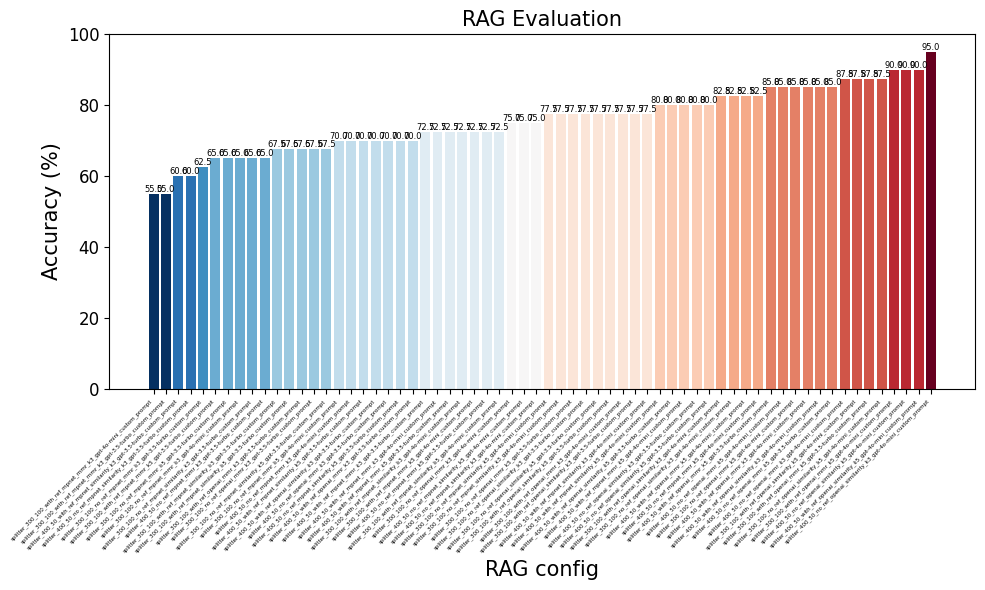

In [64]:
import matplotlib.pyplot as plt

experiments = avg_scores.index
normalized_scores = avg_scores.values

# Create color map based on the normalized scores
norm = plt.Normalize(normalized_scores.min(), normalized_scores.max())
colors = plt.cm.get_cmap("RdBu_r")(
    norm(normalized_scores)
)  # reverse bluered to redblue

plt.figure(figsize=(10, 6))
bars = plt.bar(experiments, normalized_scores, color=colors)
plt.xlabel("RAG config", fontsize=15)
plt.ylabel("Accuracy (%)", fontsize=15)
plt.title(f"RAG Evaluation", fontsize=15)
plt.ylim(0, 100)
plt.xticks(rotation=45, ha="right", fontsize=4)
plt.yticks(fontsize=12)

# Add text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval:.1f}",
        ha="center",
        va="bottom",
        fontsize=6,
    )

plt.tight_layout()
plt.show()